
## Avant de commencer le TP, 
- vérifiez que vous êtes sur un environnement GPU et python 3 : 
  
  Éxecution -> Modifier le type d'éxecution -> Type d'éxecution = python2, Accélerateur matériel = GPU

- Fichier -> Sauvegarder une copie dans mon drive

In [1]:
# It will reload all changed modules every time before executing a new line
%load_ext autoreload
%autoreload 2



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/My Drive/git/RDFIA/TME 5-6")
!ls

Mounted at /content/gdrive
'cours a.pdf'		       'Rapport TME 5-6.docx'
'cours b.pdf'		        TP_5_6_CNN_Deep_Learning_Sorbonne.ipynb
'cours c.pdf'		        tp5-6.pdf
 deep-learning-polytech-tp6-7  '~WRL0003.tmp'
'~$pport TME 5-6.docx'	       '~WRL0140.tmp'


In [3]:
!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git

fatal: destination path 'deep-learning-polytech-tp6-7' already exists and is not an empty directory.


In [4]:
cd deep-learning-polytech-tp6-7

/content/gdrive/My Drive/git/RDFIA/TME 5-6/deep-learning-polytech-tp6-7


In [5]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tme6 import *

PRINT_INTERVAL = 200
PATH="datasets"

In [6]:
class ConvNet(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, (5, 5), stride=1, padding=2),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(400, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv
        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input
        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.MNIST(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.MNIST(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


=== EPOCH 1 =====

[TRAIN Batch 000/469]	Time 0.120s (0.120s)	Loss 2.3098 (2.3098)	Prec@1  14.1 ( 14.1)	Prec@5  46.9 ( 46.9)


<Figure size 432x288 with 0 Axes>

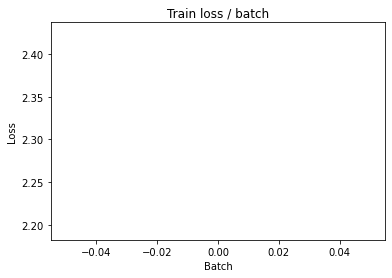

[TRAIN Batch 200/469]	Time 0.014s (0.020s)	Loss 0.3926 (1.2509)	Prec@1  92.2 ( 65.8)	Prec@5  98.4 ( 90.4)


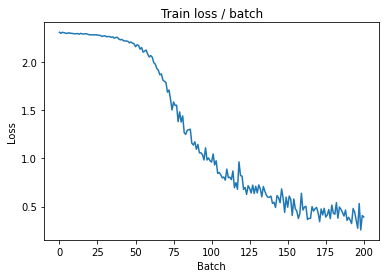

[TRAIN Batch 400/469]	Time 0.020s (0.019s)	Loss 0.2282 (0.7536)	Prec@1  93.8 ( 79.4)	Prec@5 100.0 ( 95.0)


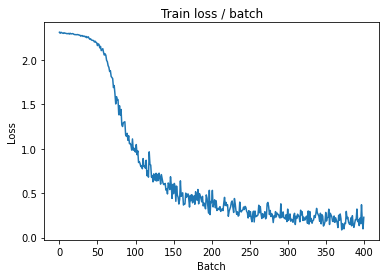


===============> Total time 9s	Avg loss 0.6664	Avg Prec@1 81.72 %	Avg Prec@5 95.73 %

[EVAL Batch 000/079]	Time 0.114s (0.114s)	Loss 0.0955 (0.0955)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.1455	Avg Prec@1 95.67 %	Avg Prec@5 99.93 %



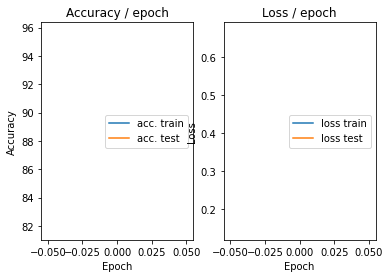

=== EPOCH 2 =====

[TRAIN Batch 000/469]	Time 0.109s (0.109s)	Loss 0.1704 (0.1704)	Prec@1  95.3 ( 95.3)	Prec@5 100.0 (100.0)


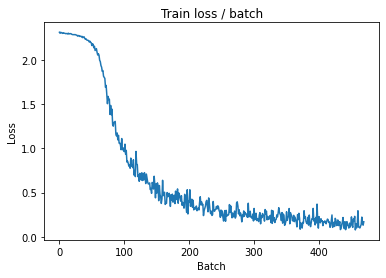

[TRAIN Batch 200/469]	Time 0.025s (0.020s)	Loss 0.1166 (0.1254)	Prec@1  96.1 ( 96.3)	Prec@5 100.0 ( 99.9)


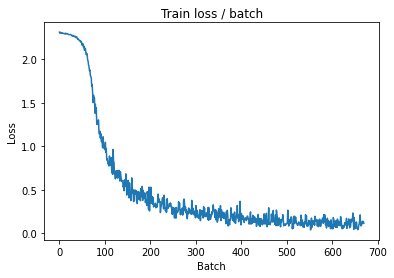

[TRAIN Batch 400/469]	Time 0.014s (0.020s)	Loss 0.0566 (0.1121)	Prec@1  98.4 ( 96.7)	Prec@5 100.0 ( 99.9)


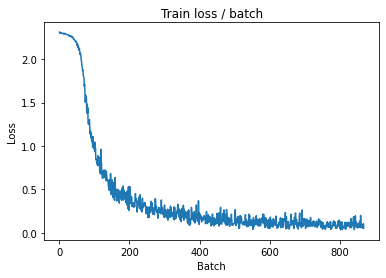


===============> Total time 9s	Avg loss 0.1090	Avg Prec@1 96.80 %	Avg Prec@5 99.92 %

[EVAL Batch 000/079]	Time 0.116s (0.116s)	Loss 0.0355 (0.0355)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0750	Avg Prec@1 97.62 %	Avg Prec@5 99.99 %



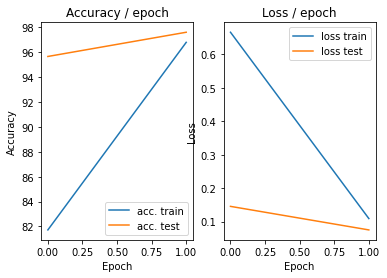

=== EPOCH 3 =====

[TRAIN Batch 000/469]	Time 0.113s (0.113s)	Loss 0.0209 (0.0209)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


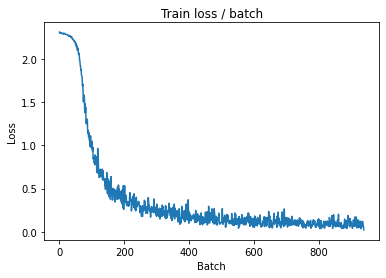

[TRAIN Batch 200/469]	Time 0.006s (0.019s)	Loss 0.0497 (0.0759)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


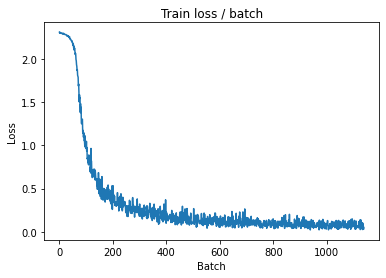

[TRAIN Batch 400/469]	Time 0.026s (0.019s)	Loss 0.0628 (0.0731)	Prec@1  97.7 ( 97.8)	Prec@5 100.0 (100.0)


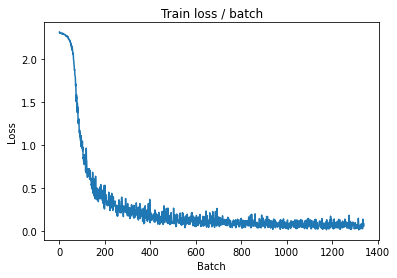


===============> Total time 9s	Avg loss 0.0740	Avg Prec@1 97.78 %	Avg Prec@5 99.96 %

[EVAL Batch 000/079]	Time 0.100s (0.100s)	Loss 0.0256 (0.0256)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0584	Avg Prec@1 98.16 %	Avg Prec@5 99.98 %



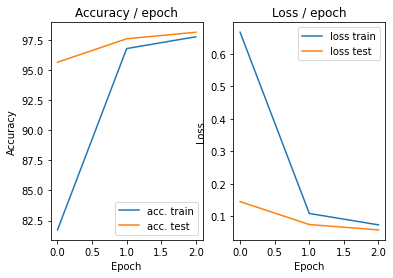

=== EPOCH 4 =====

[TRAIN Batch 000/469]	Time 0.124s (0.124s)	Loss 0.0431 (0.0431)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


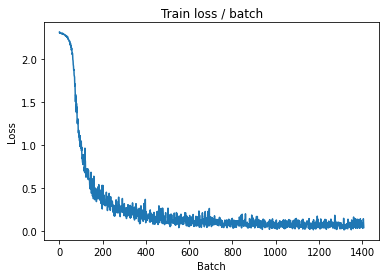

[TRAIN Batch 200/469]	Time 0.014s (0.020s)	Loss 0.0631 (0.0626)	Prec@1  98.4 ( 98.2)	Prec@5 100.0 (100.0)


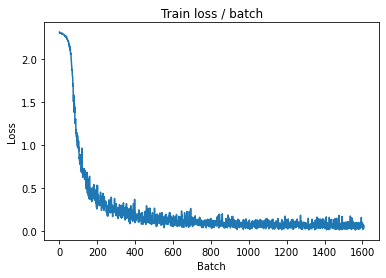

[TRAIN Batch 400/469]	Time 0.008s (0.019s)	Loss 0.1169 (0.0587)	Prec@1  96.9 ( 98.3)	Prec@5 100.0 (100.0)


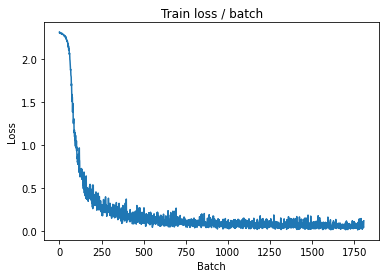


===============> Total time 9s	Avg loss 0.0585	Avg Prec@1 98.29 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.108s (0.108s)	Loss 0.0211 (0.0211)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0482	Avg Prec@1 98.47 %	Avg Prec@5 100.00 %



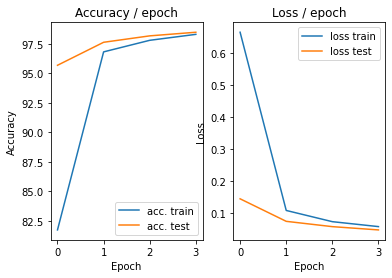

=== EPOCH 5 =====

[TRAIN Batch 000/469]	Time 0.115s (0.115s)	Loss 0.0163 (0.0163)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


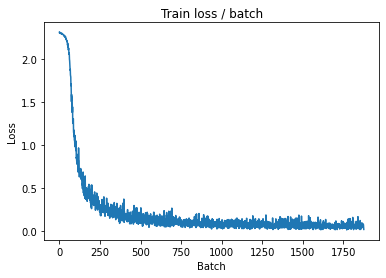

[TRAIN Batch 200/469]	Time 0.029s (0.019s)	Loss 0.0333 (0.0510)	Prec@1  99.2 ( 98.5)	Prec@5 100.0 (100.0)


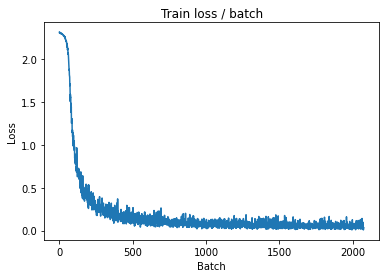

[TRAIN Batch 400/469]	Time 0.006s (0.018s)	Loss 0.0662 (0.0492)	Prec@1  99.2 ( 98.5)	Prec@5 100.0 (100.0)


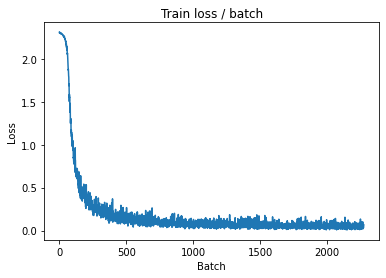


===============> Total time 8s	Avg loss 0.0494	Avg Prec@1 98.55 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.112s (0.112s)	Loss 0.0184 (0.0184)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0482	Avg Prec@1 98.39 %	Avg Prec@5 100.00 %



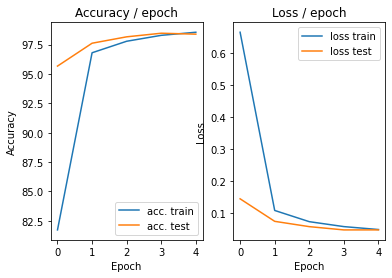

In [ ]:
main(128, 0.1, cuda=True)

### Modifiez le code pour utiliser la base CIFAR-10 et implémenter l’architecture demandée ci-dessus. (la classe est datasets.CIFAR10 ). 
### Attention à bien faire suffisament d’epoques pour que le modèle ait fini de converger.

remplacer MNIST par CIFAR10 dans dataset

In [ ]:
class ConvNet2(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet2, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv

        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input

        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss

def main2(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet2()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.143s (0.143s)	Loss 2.3026 (2.3026)	Prec@1  12.5 ( 12.5)	Prec@5  47.7 ( 47.7)


<Figure size 432x288 with 0 Axes>

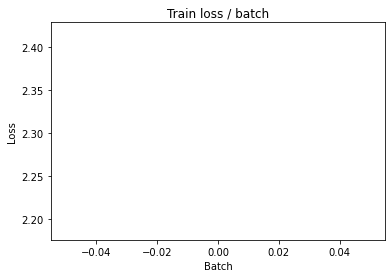

[TRAIN Batch 200/391]	Time 0.028s (0.025s)	Loss 2.3285 (2.2545)	Prec@1  12.5 ( 14.9)	Prec@5  63.3 ( 60.0)


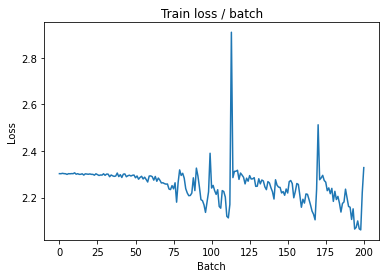


===============> Total time 9s	Avg loss 2.1530	Avg Prec@1 20.16 %	Avg Prec@5 67.89 %

[EVAL Batch 000/079]	Time 0.134s (0.134s)	Loss 1.9637 (1.9637)	Prec@1  34.4 ( 34.4)	Prec@5  85.2 ( 85.2)

===============> Total time 1s	Avg loss 2.0074	Avg Prec@1 29.18 %	Avg Prec@5 79.95 %



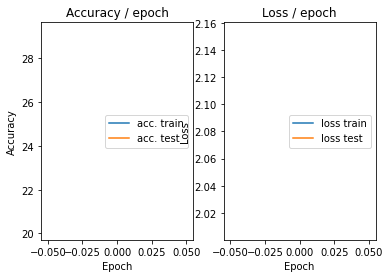

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.141s (0.141s)	Loss 2.0053 (2.0053)	Prec@1  24.2 ( 24.2)	Prec@5  79.7 ( 79.7)


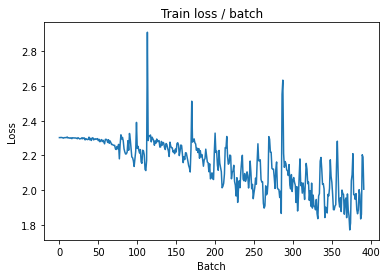

[TRAIN Batch 200/391]	Time 0.012s (0.025s)	Loss 1.6519 (1.8638)	Prec@1  38.3 ( 32.8)	Prec@5  91.4 ( 83.3)


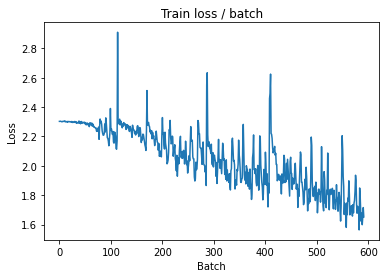


===============> Total time 9s	Avg loss 1.7491	Avg Prec@1 36.85 %	Avg Prec@5 86.16 %

[EVAL Batch 000/079]	Time 0.130s (0.130s)	Loss 1.4536 (1.4536)	Prec@1  50.0 ( 50.0)	Prec@5  91.4 ( 91.4)

===============> Total time 1s	Avg loss 1.5526	Avg Prec@1 44.19 %	Avg Prec@5 90.68 %



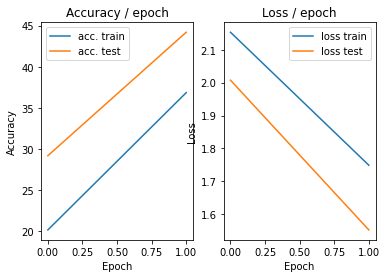

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.147s (0.147s)	Loss 1.4582 (1.4582)	Prec@1  46.9 ( 46.9)	Prec@5  93.8 ( 93.8)


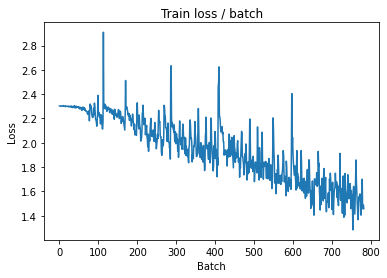

[TRAIN Batch 200/391]	Time 0.024s (0.025s)	Loss 1.2107 (1.4889)	Prec@1  60.2 ( 46.8)	Prec@5  96.1 ( 91.7)


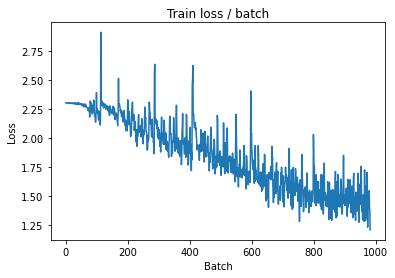


===============> Total time 9s	Avg loss 1.4423	Avg Prec@1 48.38 %	Avg Prec@5 92.36 %

[EVAL Batch 000/079]	Time 0.138s (0.138s)	Loss 1.2198 (1.2198)	Prec@1  62.5 ( 62.5)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.3597	Avg Prec@1 50.78 %	Avg Prec@5 93.50 %



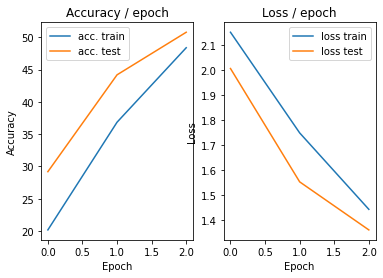

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.156s (0.156s)	Loss 1.3503 (1.3503)	Prec@1  54.7 ( 54.7)	Prec@5  89.8 ( 89.8)


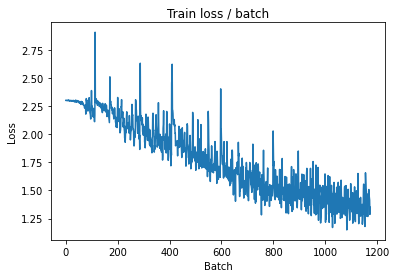

[TRAIN Batch 200/391]	Time 0.022s (0.025s)	Loss 1.1734 (1.2868)	Prec@1  57.0 ( 54.3)	Prec@5  96.1 ( 94.1)


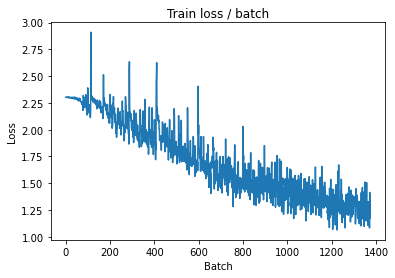


===============> Total time 9s	Avg loss 1.2660	Avg Prec@1 54.84 %	Avg Prec@5 94.49 %

[EVAL Batch 000/079]	Time 0.142s (0.142s)	Loss 1.1894 (1.1894)	Prec@1  52.3 ( 52.3)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 1.3306	Avg Prec@1 52.36 %	Avg Prec@5 93.55 %



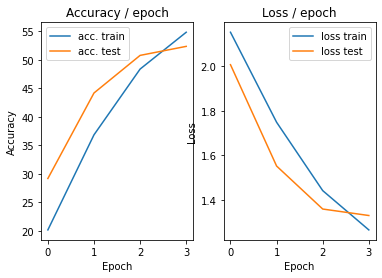

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.142s (0.142s)	Loss 1.2518 (1.2518)	Prec@1  57.8 ( 57.8)	Prec@5  96.1 ( 96.1)


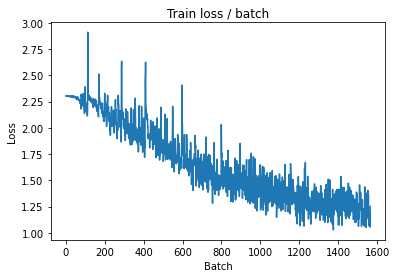

[TRAIN Batch 200/391]	Time 0.026s (0.025s)	Loss 1.0029 (1.1630)	Prec@1  70.3 ( 58.7)	Prec@5  95.3 ( 95.5)


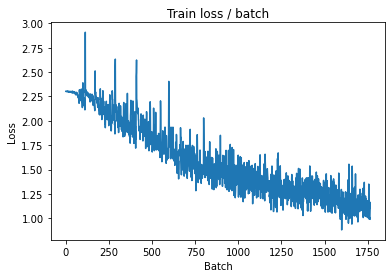


===============> Total time 9s	Avg loss 1.1347	Avg Prec@1 59.94 %	Avg Prec@5 95.70 %

[EVAL Batch 000/079]	Time 0.130s (0.130s)	Loss 0.9569 (0.9569)	Prec@1  64.1 ( 64.1)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.1134	Avg Prec@1 60.12 %	Avg Prec@5 95.95 %



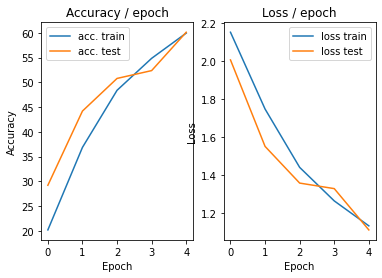

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.148s (0.148s)	Loss 0.9913 (0.9913)	Prec@1  66.4 ( 66.4)	Prec@5  96.1 ( 96.1)


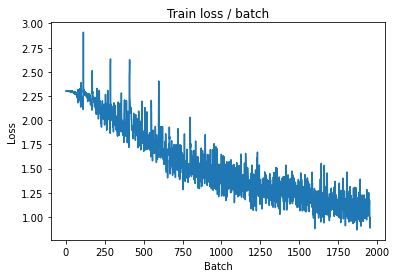

[TRAIN Batch 200/391]	Time 0.015s (0.025s)	Loss 1.0410 (1.0278)	Prec@1  60.9 ( 64.0)	Prec@5  98.4 ( 96.5)


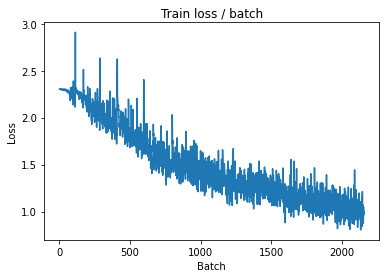


===============> Total time 9s	Avg loss 1.0127	Avg Prec@1 64.47 %	Avg Prec@5 96.60 %

[EVAL Batch 000/079]	Time 0.121s (0.121s)	Loss 1.0035 (1.0035)	Prec@1  67.2 ( 67.2)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.1283	Avg Prec@1 59.78 %	Avg Prec@5 95.67 %



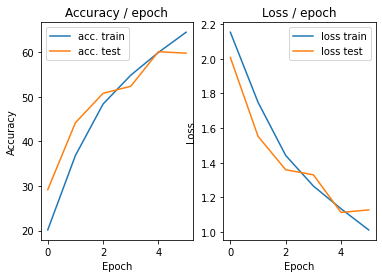

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.158s (0.158s)	Loss 1.0641 (1.0641)	Prec@1  61.7 ( 61.7)	Prec@5  96.1 ( 96.1)


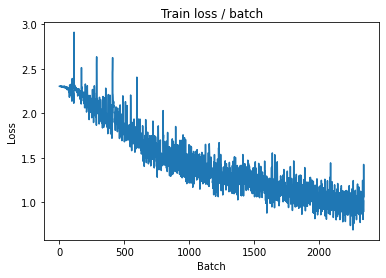

[TRAIN Batch 200/391]	Time 0.025s (0.025s)	Loss 0.9316 (0.9079)	Prec@1  71.1 ( 68.3)	Prec@5  96.1 ( 97.5)


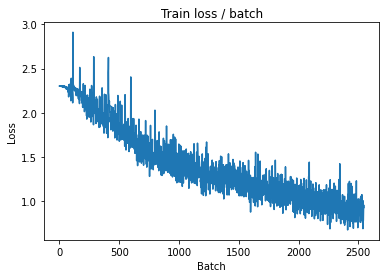


===============> Total time 9s	Avg loss 0.8995	Avg Prec@1 68.47 %	Avg Prec@5 97.56 %

[EVAL Batch 000/079]	Time 0.135s (0.135s)	Loss 0.9644 (0.9644)	Prec@1  67.2 ( 67.2)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.0335	Avg Prec@1 63.82 %	Avg Prec@5 96.36 %



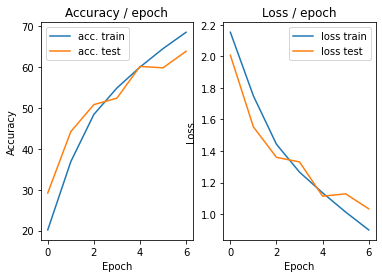

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.148s (0.148s)	Loss 0.8166 (0.8166)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)


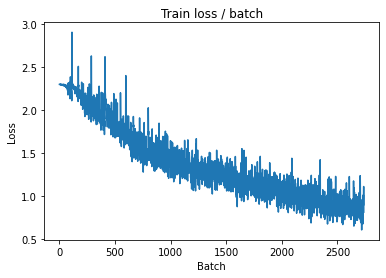

[TRAIN Batch 200/391]	Time 0.017s (0.024s)	Loss 0.6804 (0.7950)	Prec@1  76.6 ( 72.2)	Prec@5  99.2 ( 98.0)


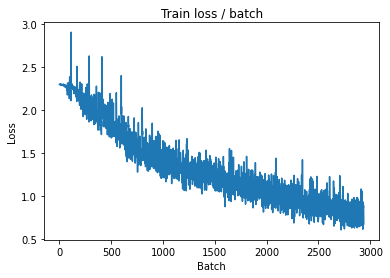


===============> Total time 9s	Avg loss 0.7936	Avg Prec@1 72.26 %	Avg Prec@5 98.07 %

[EVAL Batch 000/079]	Time 0.141s (0.141s)	Loss 1.0387 (1.0387)	Prec@1  68.8 ( 68.8)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.0580	Avg Prec@1 63.22 %	Avg Prec@5 96.43 %



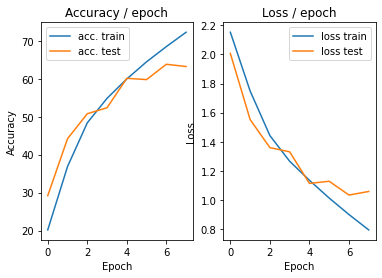

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.156s (0.156s)	Loss 0.8433 (0.8433)	Prec@1  71.9 ( 71.9)	Prec@5  98.4 ( 98.4)


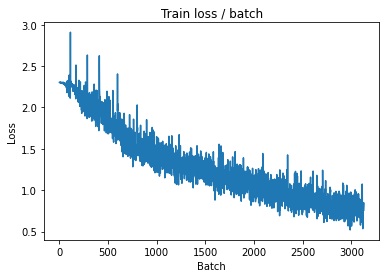

[TRAIN Batch 200/391]	Time 0.033s (0.025s)	Loss 0.8301 (0.6872)	Prec@1  74.2 ( 75.9)	Prec@5  97.7 ( 98.6)


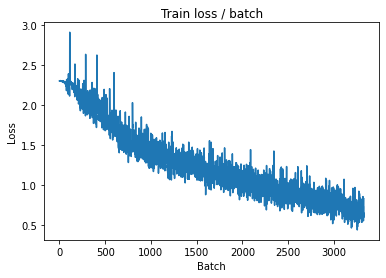


===============> Total time 9s	Avg loss 0.6958	Avg Prec@1 75.63 %	Avg Prec@5 98.58 %

[EVAL Batch 000/079]	Time 0.130s (0.130s)	Loss 1.0001 (1.0001)	Prec@1  67.2 ( 67.2)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 0.9692	Avg Prec@1 67.37 %	Avg Prec@5 97.03 %



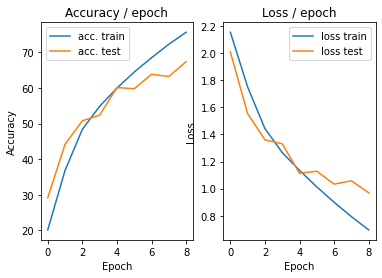

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.147s (0.147s)	Loss 0.6280 (0.6280)	Prec@1  79.7 ( 79.7)	Prec@5  99.2 ( 99.2)


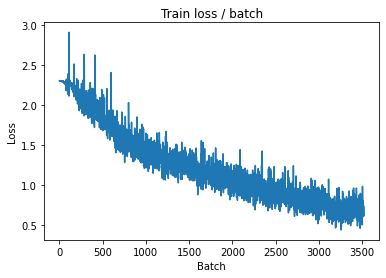

[TRAIN Batch 200/391]	Time 0.026s (0.026s)	Loss 0.6515 (0.6026)	Prec@1  76.6 ( 79.0)	Prec@5  97.7 ( 99.0)


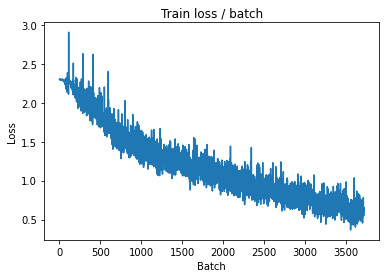


===============> Total time 9s	Avg loss 0.6051	Avg Prec@1 78.88 %	Avg Prec@5 98.98 %

[EVAL Batch 000/079]	Time 0.143s (0.143s)	Loss 0.9334 (0.9334)	Prec@1  71.9 ( 71.9)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 0.9526	Avg Prec@1 68.12 %	Avg Prec@5 96.96 %



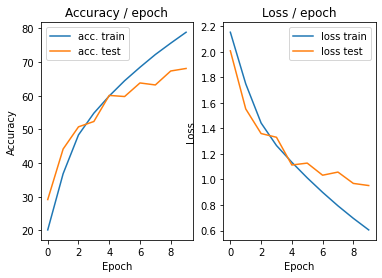

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.153s (0.153s)	Loss 0.5188 (0.5188)	Prec@1  81.2 ( 81.2)	Prec@5  98.4 ( 98.4)


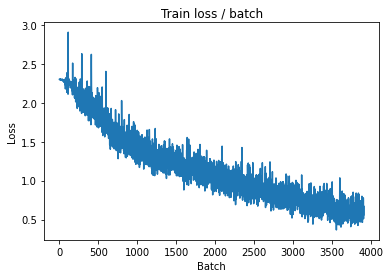

[TRAIN Batch 200/391]	Time 0.015s (0.024s)	Loss 0.4752 (0.4885)	Prec@1  82.8 ( 82.9)	Prec@5 100.0 ( 99.4)


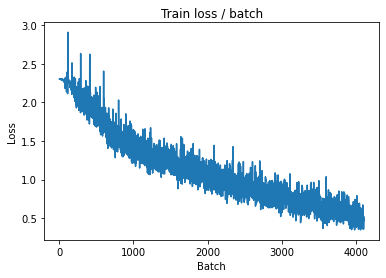


===============> Total time 9s	Avg loss 0.5082	Avg Prec@1 82.20 %	Avg Prec@5 99.34 %

[EVAL Batch 000/079]	Time 0.149s (0.149s)	Loss 0.9451 (0.9451)	Prec@1  69.5 ( 69.5)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 0.9376	Avg Prec@1 70.09 %	Avg Prec@5 97.38 %



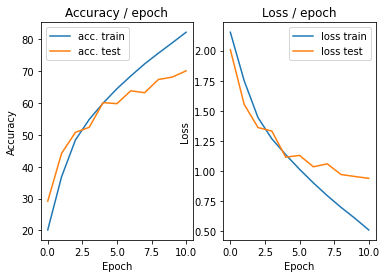

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.142s (0.142s)	Loss 0.3385 (0.3385)	Prec@1  86.7 ( 86.7)	Prec@5 100.0 (100.0)


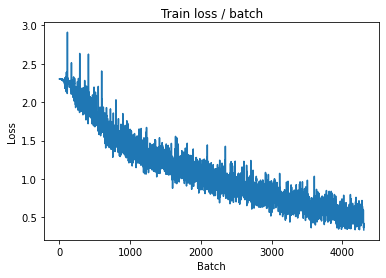

[TRAIN Batch 200/391]	Time 0.030s (0.025s)	Loss 0.3376 (0.4155)	Prec@1  85.9 ( 85.4)	Prec@5  99.2 ( 99.7)


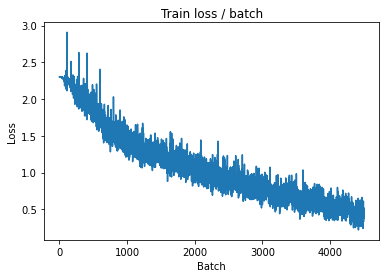


===============> Total time 9s	Avg loss 0.4239	Avg Prec@1 85.17 %	Avg Prec@5 99.63 %

[EVAL Batch 000/079]	Time 0.124s (0.124s)	Loss 1.1023 (1.1023)	Prec@1  64.1 ( 64.1)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 0.9971	Avg Prec@1 69.51 %	Avg Prec@5 97.17 %



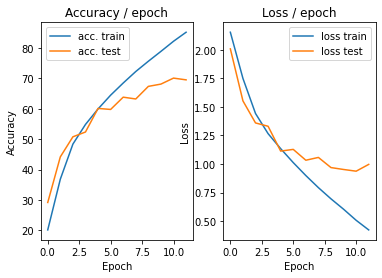

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.140s (0.140s)	Loss 0.2696 (0.2696)	Prec@1  90.6 ( 90.6)	Prec@5 100.0 (100.0)


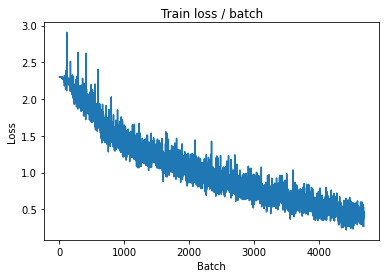

[TRAIN Batch 200/391]	Time 0.019s (0.025s)	Loss 0.2395 (0.3047)	Prec@1  91.4 ( 89.5)	Prec@5 100.0 ( 99.8)


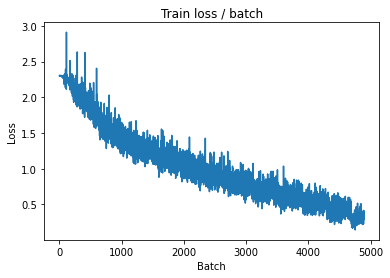


===============> Total time 9s	Avg loss 0.3250	Avg Prec@1 88.71 %	Avg Prec@5 99.82 %

[EVAL Batch 000/079]	Time 0.132s (0.132s)	Loss 1.1027 (1.1027)	Prec@1  64.8 ( 64.8)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.0790	Avg Prec@1 69.88 %	Avg Prec@5 97.36 %



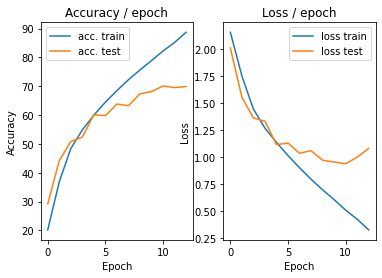

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.148s (0.148s)	Loss 0.2328 (0.2328)	Prec@1  92.2 ( 92.2)	Prec@5 100.0 (100.0)


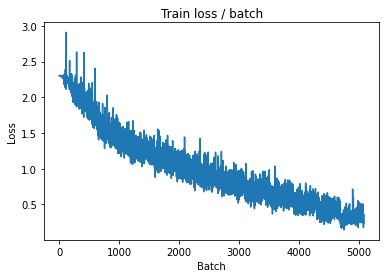

[TRAIN Batch 200/391]	Time 0.019s (0.025s)	Loss 0.3681 (0.2187)	Prec@1  85.9 ( 92.7)	Prec@5 100.0 ( 99.9)


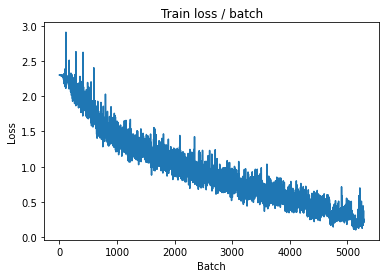


===============> Total time 9s	Avg loss 0.2404	Avg Prec@1 91.85 %	Avg Prec@5 99.88 %

[EVAL Batch 000/079]	Time 0.138s (0.138s)	Loss 1.1346 (1.1346)	Prec@1  69.5 ( 69.5)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.1401	Avg Prec@1 68.85 %	Avg Prec@5 97.23 %



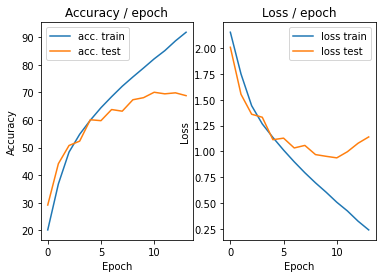

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.134s (0.134s)	Loss 0.1833 (0.1833)	Prec@1  94.5 ( 94.5)	Prec@5 100.0 (100.0)


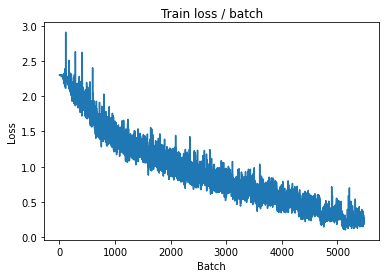

[TRAIN Batch 200/391]	Time 0.035s (0.025s)	Loss 0.1020 (0.1464)	Prec@1  99.2 ( 95.1)	Prec@5 100.0 (100.0)


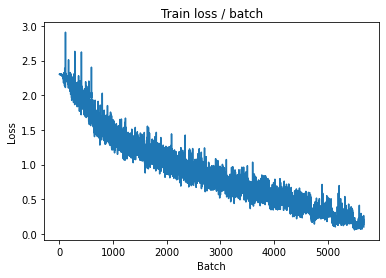


===============> Total time 9s	Avg loss 0.1758	Avg Prec@1 93.95 %	Avg Prec@5 99.96 %

[EVAL Batch 000/079]	Time 0.139s (0.139s)	Loss 1.3419 (1.3419)	Prec@1  70.3 ( 70.3)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.3215	Avg Prec@1 68.55 %	Avg Prec@5 96.89 %



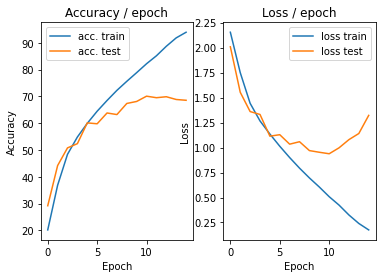

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.148s (0.148s)	Loss 0.1081 (0.1081)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


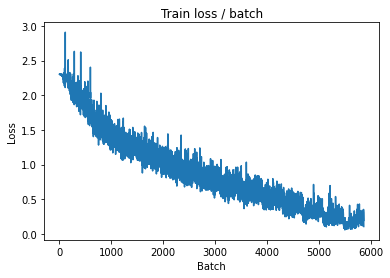

[TRAIN Batch 200/391]	Time 0.023s (0.025s)	Loss 0.1126 (0.1017)	Prec@1  94.5 ( 96.8)	Prec@5 100.0 (100.0)


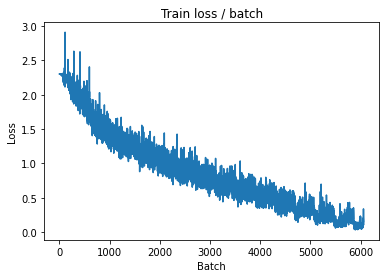


===============> Total time 9s	Avg loss 0.1171	Avg Prec@1 96.14 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.131s (0.131s)	Loss 1.6606 (1.6606)	Prec@1  67.2 ( 67.2)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.5820	Avg Prec@1 67.13 %	Avg Prec@5 96.58 %



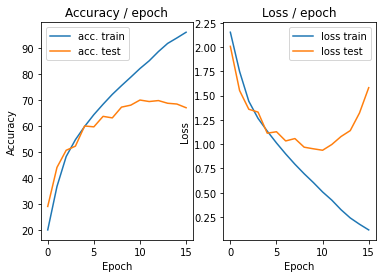

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.137s (0.137s)	Loss 0.2817 (0.2817)	Prec@1  89.1 ( 89.1)	Prec@5 100.0 (100.0)


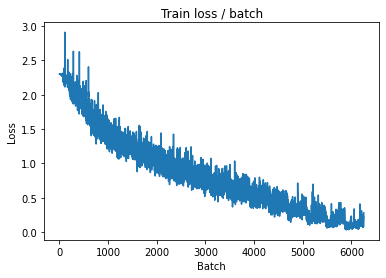

[TRAIN Batch 200/391]	Time 0.019s (0.025s)	Loss 0.1127 (0.0765)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


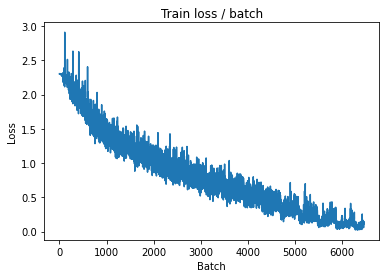


===============> Total time 9s	Avg loss 0.0955	Avg Prec@1 96.95 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.121s (0.121s)	Loss 1.6423 (1.6423)	Prec@1  68.8 ( 68.8)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.4135	Avg Prec@1 70.39 %	Avg Prec@5 97.06 %



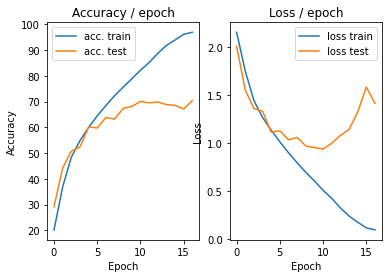

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.137s (0.137s)	Loss 0.0747 (0.0747)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


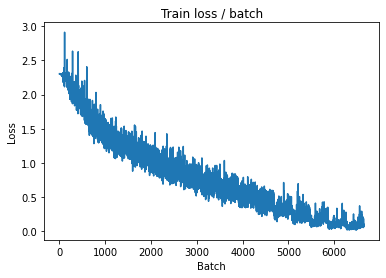

[TRAIN Batch 200/391]	Time 0.021s (0.025s)	Loss 0.0715 (0.0625)	Prec@1  98.4 ( 98.2)	Prec@5 100.0 (100.0)


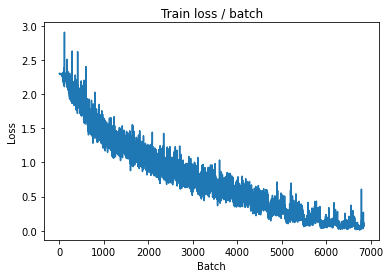


===============> Total time 9s	Avg loss 0.0720	Avg Prec@1 97.79 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.131s (0.131s)	Loss 2.0775 (2.0775)	Prec@1  66.4 ( 66.4)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.6136	Avg Prec@1 68.33 %	Avg Prec@5 96.96 %



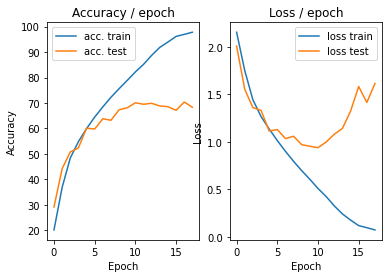

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.153s (0.153s)	Loss 0.0735 (0.0735)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


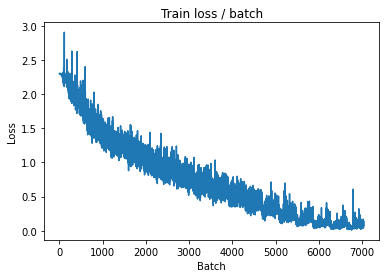

[TRAIN Batch 200/391]	Time 0.034s (0.025s)	Loss 0.0356 (0.0428)	Prec@1  99.2 ( 98.7)	Prec@5 100.0 (100.0)


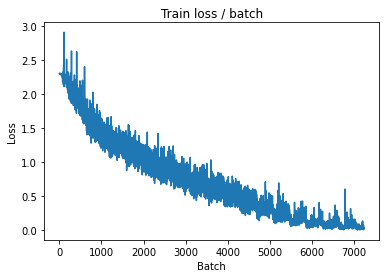


===============> Total time 9s	Avg loss 0.0507	Avg Prec@1 98.41 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.129s (0.129s)	Loss 1.9186 (1.9186)	Prec@1  73.4 ( 73.4)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.6342	Avg Prec@1 70.27 %	Avg Prec@5 97.01 %



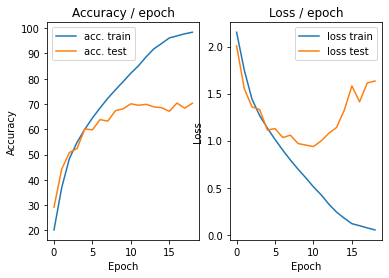

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.148s (0.148s)	Loss 0.0349 (0.0349)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


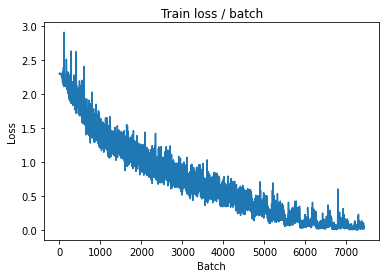

[TRAIN Batch 200/391]	Time 0.019s (0.025s)	Loss 0.0625 (0.0313)	Prec@1  97.7 ( 99.1)	Prec@5 100.0 (100.0)


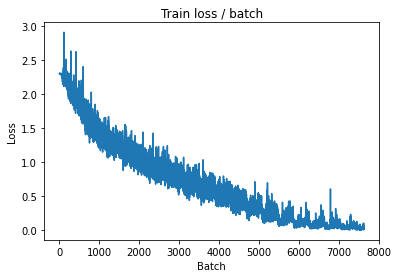


===============> Total time 9s	Avg loss 0.0334	Avg Prec@1 99.01 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.138s (0.138s)	Loss 2.2035 (2.2035)	Prec@1  72.7 ( 72.7)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.7610	Avg Prec@1 70.45 %	Avg Prec@5 97.32 %



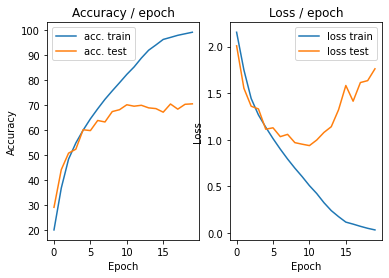

=== EPOCH 21 =====

[TRAIN Batch 000/391]	Time 0.152s (0.152s)	Loss 0.0523 (0.0523)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


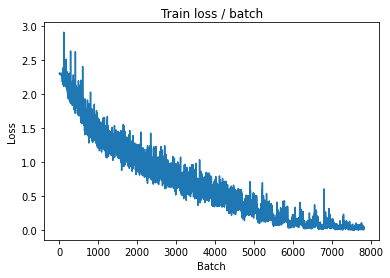

[TRAIN Batch 200/391]	Time 0.020s (0.026s)	Loss 0.0686 (0.0182)	Prec@1  98.4 ( 99.6)	Prec@5 100.0 (100.0)


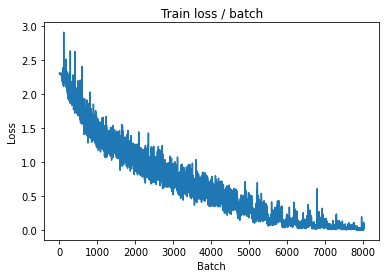


===============> Total time 9s	Avg loss 0.0232	Avg Prec@1 99.38 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.137s (0.137s)	Loss 1.9284 (1.9284)	Prec@1  71.1 ( 71.1)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.9217	Avg Prec@1 69.20 %	Avg Prec@5 97.17 %



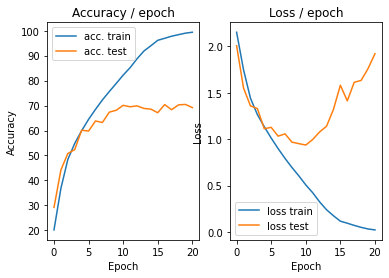

=== EPOCH 22 =====

[TRAIN Batch 000/391]	Time 0.150s (0.150s)	Loss 0.0357 (0.0357)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


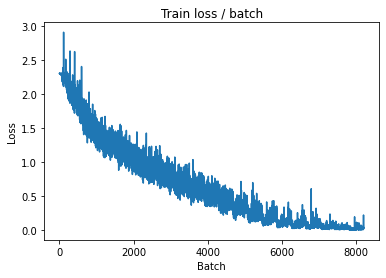

[TRAIN Batch 200/391]	Time 0.027s (0.025s)	Loss 0.0455 (0.0200)	Prec@1  99.2 ( 99.4)	Prec@5 100.0 (100.0)


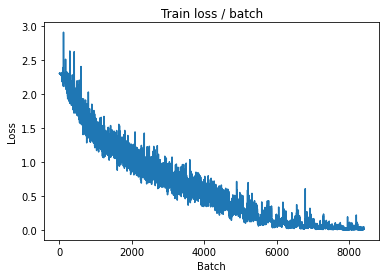


===============> Total time 9s	Avg loss 0.0334	Avg Prec@1 98.97 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.132s (0.132s)	Loss 2.0474 (2.0474)	Prec@1  72.7 ( 72.7)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 2.0602	Avg Prec@1 68.50 %	Avg Prec@5 96.28 %



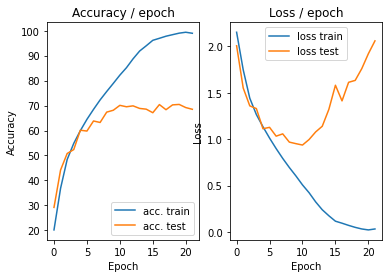

=== EPOCH 23 =====

[TRAIN Batch 000/391]	Time 0.139s (0.139s)	Loss 0.1017 (0.1017)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


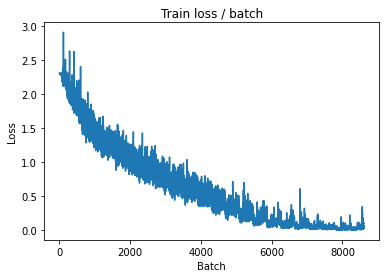

[TRAIN Batch 200/391]	Time 0.008s (0.024s)	Loss 0.0147 (0.0361)	Prec@1  99.2 ( 98.8)	Prec@5 100.0 (100.0)


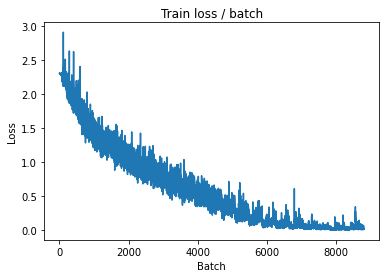


===============> Total time 9s	Avg loss 0.0295	Avg Prec@1 99.09 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.126s (0.126s)	Loss 1.9111 (1.9111)	Prec@1  71.9 ( 71.9)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.9853	Avg Prec@1 70.53 %	Avg Prec@5 97.15 %



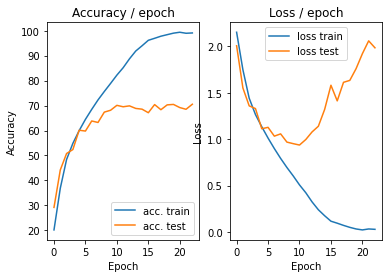

=== EPOCH 24 =====

[TRAIN Batch 000/391]	Time 0.147s (0.147s)	Loss 0.0061 (0.0061)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


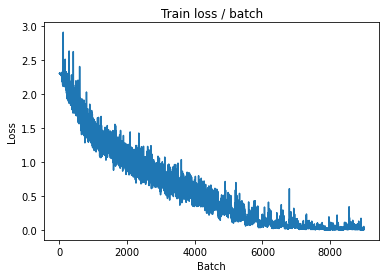

[TRAIN Batch 200/391]	Time 0.021s (0.025s)	Loss 0.0345 (0.0268)	Prec@1  98.4 ( 99.2)	Prec@5 100.0 (100.0)


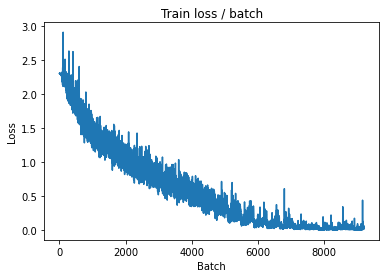


===============> Total time 9s	Avg loss 0.0657	Avg Prec@1 98.08 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.131s (0.131s)	Loss 1.4948 (1.4948)	Prec@1  73.4 ( 73.4)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.5862	Avg Prec@1 69.44 %	Avg Prec@5 96.56 %



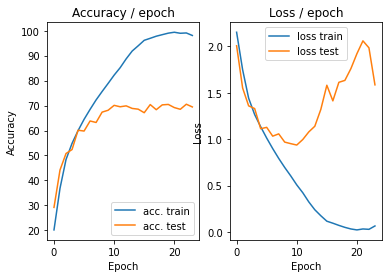

=== EPOCH 25 =====

[TRAIN Batch 000/391]	Time 0.160s (0.160s)	Loss 0.0271 (0.0271)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


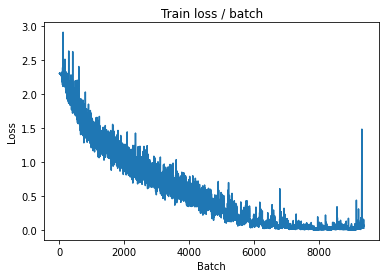

[TRAIN Batch 200/391]	Time 0.014s (0.025s)	Loss 0.0202 (0.0253)	Prec@1  99.2 ( 99.3)	Prec@5 100.0 (100.0)


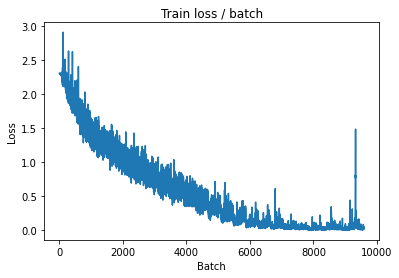


===============> Total time 9s	Avg loss 0.0228	Avg Prec@1 99.36 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.137s (0.137s)	Loss 2.0986 (2.0986)	Prec@1  69.5 ( 69.5)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.9542	Avg Prec@1 71.15 %	Avg Prec@5 97.20 %



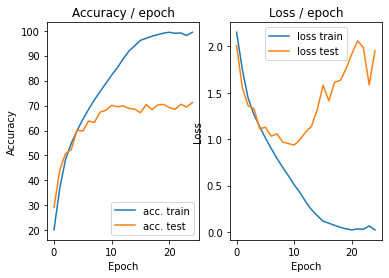

=== EPOCH 26 =====

[TRAIN Batch 000/391]	Time 0.150s (0.150s)	Loss 0.0096 (0.0096)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


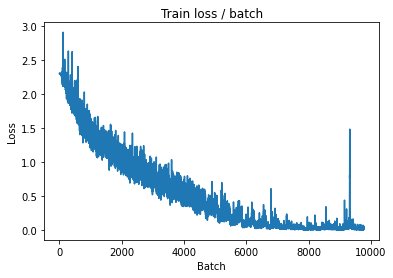

[TRAIN Batch 200/391]	Time 0.012s (0.025s)	Loss 0.0034 (0.0085)	Prec@1 100.0 ( 99.8)	Prec@5 100.0 (100.0)


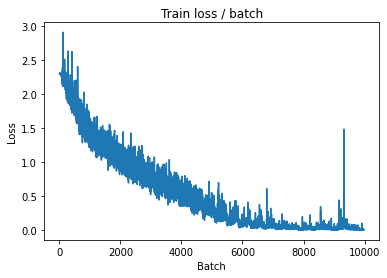


===============> Total time 9s	Avg loss 0.0071	Avg Prec@1 99.85 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.136s (0.136s)	Loss 2.0978 (2.0978)	Prec@1  70.3 ( 70.3)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 2.0721	Avg Prec@1 70.34 %	Avg Prec@5 96.99 %



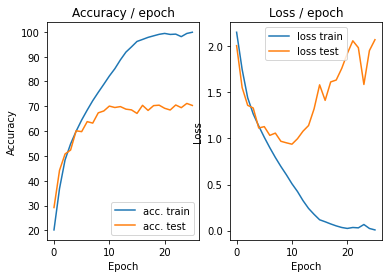

=== EPOCH 27 =====

[TRAIN Batch 000/391]	Time 0.151s (0.151s)	Loss 0.0048 (0.0048)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


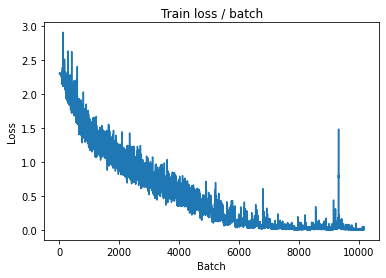

[TRAIN Batch 200/391]	Time 0.027s (0.025s)	Loss 0.0026 (0.0129)	Prec@1 100.0 ( 99.7)	Prec@5 100.0 (100.0)


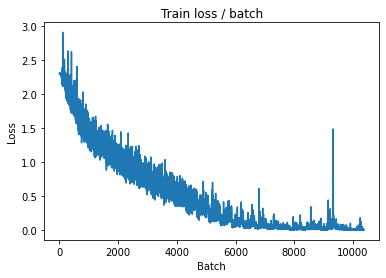


===============> Total time 9s	Avg loss 0.0095	Avg Prec@1 99.77 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.141s (0.141s)	Loss 2.1956 (2.1956)	Prec@1  73.4 ( 73.4)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 2.0061	Avg Prec@1 71.86 %	Avg Prec@5 97.25 %



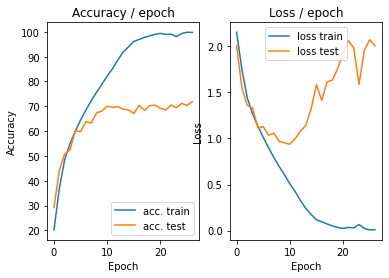

=== EPOCH 28 =====

[TRAIN Batch 000/391]	Time 0.158s (0.158s)	Loss 0.0015 (0.0015)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


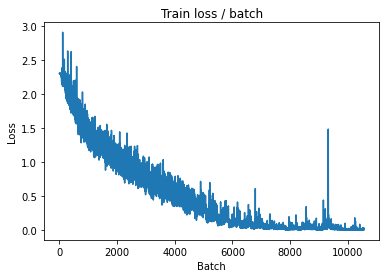

[TRAIN Batch 200/391]	Time 0.022s (0.025s)	Loss 0.0017 (0.0027)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


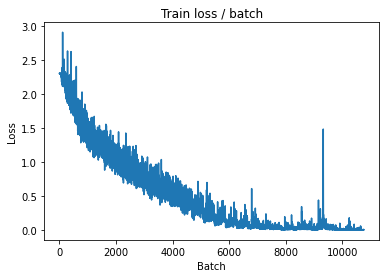


===============> Total time 9s	Avg loss 0.0023	Avg Prec@1 99.97 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.135s (0.135s)	Loss 2.1724 (2.1724)	Prec@1  70.3 ( 70.3)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 2.0566	Avg Prec@1 71.82 %	Avg Prec@5 97.33 %



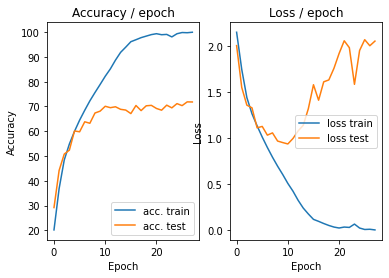

=== EPOCH 29 =====

[TRAIN Batch 000/391]	Time 0.145s (0.145s)	Loss 0.0005 (0.0005)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


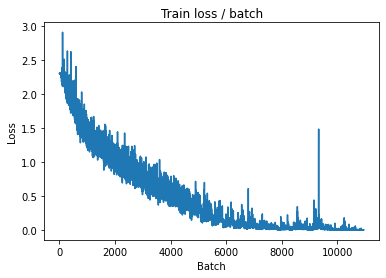

[TRAIN Batch 200/391]	Time 0.027s (0.025s)	Loss 0.0003 (0.0005)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


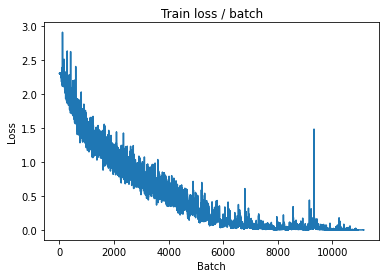


===============> Total time 9s	Avg loss 0.0005	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.131s (0.131s)	Loss 2.2685 (2.2685)	Prec@1  71.1 ( 71.1)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 2.1127	Avg Prec@1 71.80 %	Avg Prec@5 97.43 %



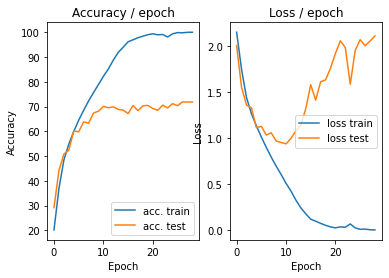

=== EPOCH 30 =====

[TRAIN Batch 000/391]	Time 0.147s (0.147s)	Loss 0.0004 (0.0004)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


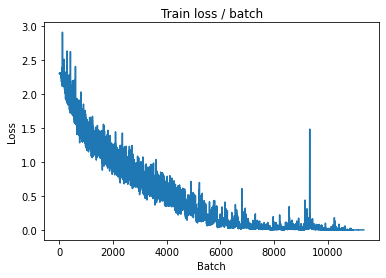

[TRAIN Batch 200/391]	Time 0.021s (0.025s)	Loss 0.0003 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


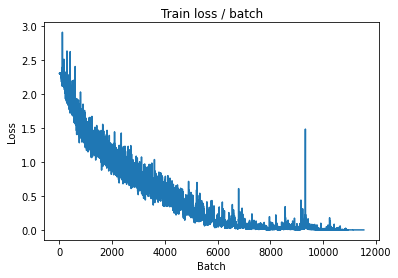


===============> Total time 9s	Avg loss 0.0003	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.131s (0.131s)	Loss 2.2967 (2.2967)	Prec@1  71.1 ( 71.1)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 2.1530	Avg Prec@1 71.95 %	Avg Prec@5 97.41 %



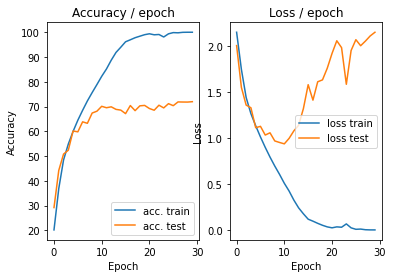

In [ ]:
main2(128, 0.1, epochs=30 ,cuda=True)

## Partie 3 – Améliorations des résultats (2 heures)

### 3.1 Normalisation des exemples

In [20]:
class ConvNet3(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet3, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv

        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input

        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201])
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201])
 
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss

def main3(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet3()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.176s (0.176s)	Loss 2.3046 (2.3046)	Prec@1  12.5 ( 12.5)	Prec@5  45.3 ( 45.3)


<Figure size 432x288 with 0 Axes>

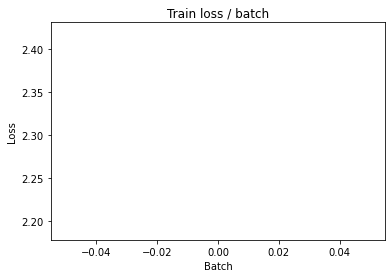

[TRAIN Batch 200/391]	Time 0.030s (0.039s)	Loss 1.7403 (1.9293)	Prec@1  29.7 ( 29.7)	Prec@5  88.3 ( 79.6)


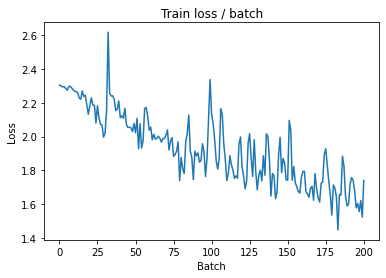


===============> Total time 15s	Avg loss 1.7382	Avg Prec@1 36.99 %	Avg Prec@5 85.12 %

[EVAL Batch 000/079]	Time 0.161s (0.161s)	Loss 1.4194 (1.4194)	Prec@1  49.2 ( 49.2)	Prec@5  94.5 ( 94.5)

===============> Total time 2s	Avg loss 1.4510	Avg Prec@1 48.44 %	Avg Prec@5 92.40 %



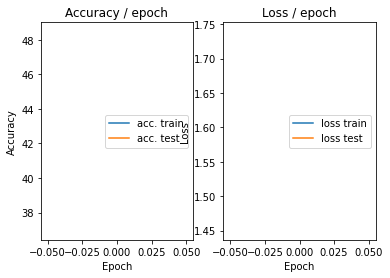

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.181s (0.181s)	Loss 1.4365 (1.4365)	Prec@1  45.3 ( 45.3)	Prec@5  92.2 ( 92.2)


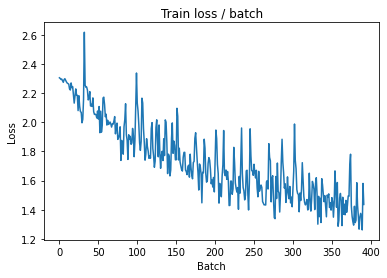

[TRAIN Batch 200/391]	Time 0.049s (0.039s)	Loss 1.4974 (1.3437)	Prec@1  47.7 ( 52.3)	Prec@5  93.8 ( 93.8)


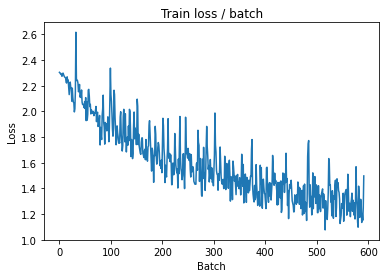

KeyboardInterrupt: ignored

In [21]:
main3(128, 0.1, epochs=15 ,cuda=True)

### 3.2 Augmentation du nombre d’exemples d’apprentissage par data augmentation

In [22]:
class ConvNet4(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet4, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv

        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input

        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201]),
            transforms.RandomCrop(28),
            transforms.RandomHorizontalFlip(),
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201]),
            transforms.CenterCrop(28),
 
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss

def main4(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet4()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.207s (0.207s)	Loss 2.2985 (2.2985)	Prec@1  14.8 ( 14.8)	Prec@5  52.3 ( 52.3)


<Figure size 432x288 with 0 Axes>

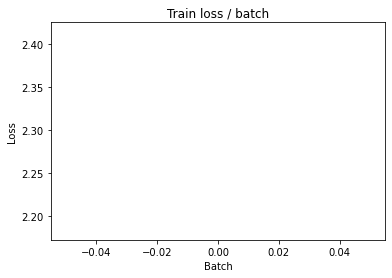

[TRAIN Batch 200/391]	Time 0.025s (0.056s)	Loss 1.6771 (1.9917)	Prec@1  34.4 ( 27.2)	Prec@5  88.3 ( 77.8)


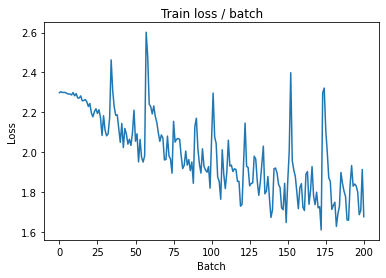


===============> Total time 21s	Avg loss 1.8164	Avg Prec@1 33.83 %	Avg Prec@5 83.46 %

[EVAL Batch 000/079]	Time 0.171s (0.171s)	Loss 1.5847 (1.5847)	Prec@1  45.3 ( 45.3)	Prec@5  88.3 ( 88.3)

===============> Total time 2s	Avg loss 1.5755	Avg Prec@1 41.88 %	Avg Prec@5 91.14 %



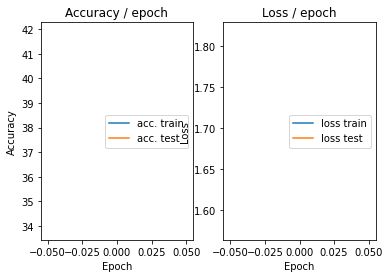

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.210s (0.210s)	Loss 1.4189 (1.4189)	Prec@1  40.6 ( 40.6)	Prec@5  95.3 ( 95.3)


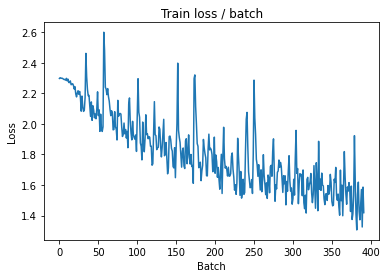

[TRAIN Batch 200/391]	Time 0.025s (0.056s)	Loss 1.4643 (1.4564)	Prec@1  46.1 ( 48.2)	Prec@5  92.2 ( 92.4)


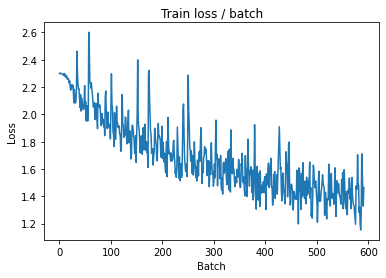


===============> Total time 21s	Avg loss 1.3925	Avg Prec@1 50.50 %	Avg Prec@5 93.17 %

[EVAL Batch 000/079]	Time 0.162s (0.162s)	Loss 1.1650 (1.1650)	Prec@1  61.7 ( 61.7)	Prec@5  93.8 ( 93.8)

===============> Total time 2s	Avg loss 1.2864	Avg Prec@1 54.49 %	Avg Prec@5 94.00 %



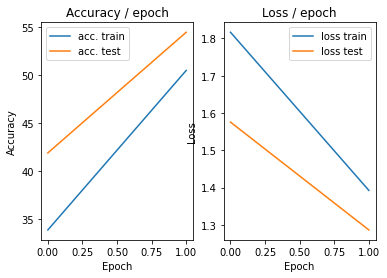

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.217s (0.217s)	Loss 1.2554 (1.2554)	Prec@1  53.9 ( 53.9)	Prec@5  94.5 ( 94.5)


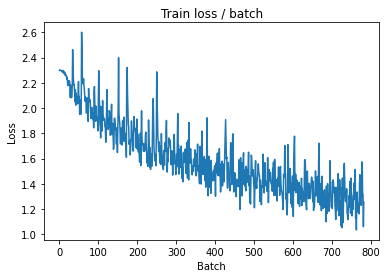

[TRAIN Batch 200/391]	Time 0.020s (0.056s)	Loss 0.9934 (1.2142)	Prec@1  67.2 ( 57.1)	Prec@5  96.9 ( 95.0)


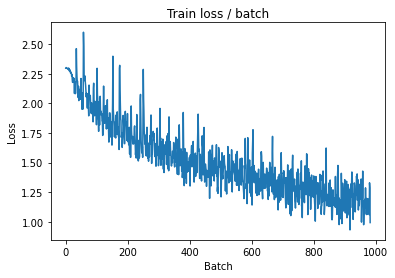


===============> Total time 21s	Avg loss 1.1714	Avg Prec@1 58.74 %	Avg Prec@5 95.31 %

[EVAL Batch 000/079]	Time 0.166s (0.166s)	Loss 1.0910 (1.0910)	Prec@1  68.0 ( 68.0)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.1655	Avg Prec@1 59.88 %	Avg Prec@5 95.00 %



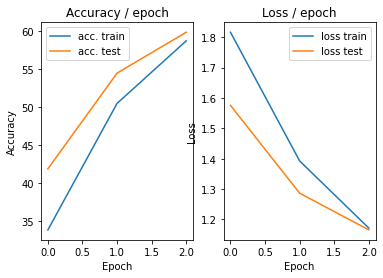

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.225s (0.225s)	Loss 1.0737 (1.0737)	Prec@1  60.2 ( 60.2)	Prec@5  96.9 ( 96.9)


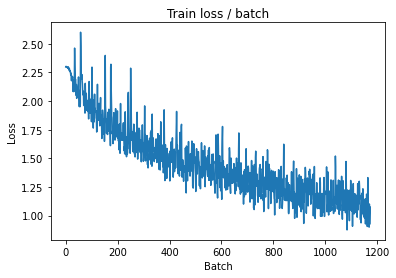

[TRAIN Batch 200/391]	Time 0.079s (0.056s)	Loss 0.9507 (1.0491)	Prec@1  64.1 ( 62.8)	Prec@5  97.7 ( 96.4)


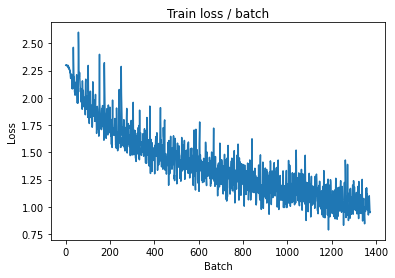


===============> Total time 21s	Avg loss 1.0248	Avg Prec@1 63.88 %	Avg Prec@5 96.51 %

[EVAL Batch 000/079]	Time 0.170s (0.170s)	Loss 1.0201 (1.0201)	Prec@1  65.6 ( 65.6)	Prec@5  96.1 ( 96.1)

===============> Total time 2s	Avg loss 0.9913	Avg Prec@1 65.21 %	Avg Prec@5 96.92 %



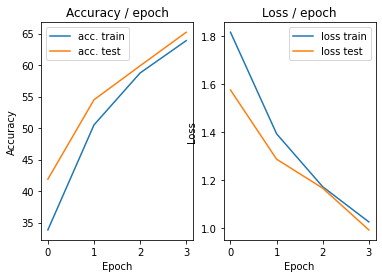

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.207s (0.207s)	Loss 1.0240 (1.0240)	Prec@1  61.7 ( 61.7)	Prec@5  98.4 ( 98.4)


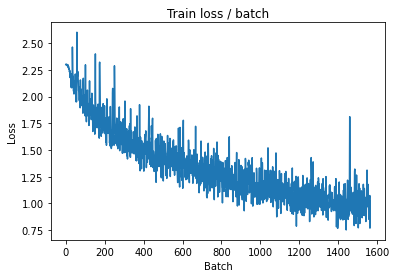

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fb9aaeb30f0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connecti

[TRAIN Batch 200/391]	Time 0.093s (0.058s)	Loss 0.9450 (0.9323)	Prec@1  67.2 ( 67.7)	Prec@5  97.7 ( 97.1)


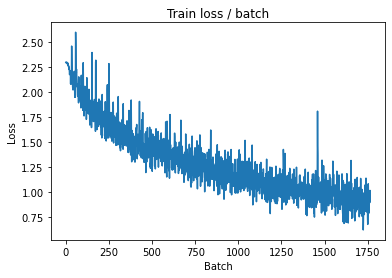


===============> Total time 22s	Avg loss 0.9128	Avg Prec@1 68.28 %	Avg Prec@5 97.24 %

[EVAL Batch 000/079]	Time 0.156s (0.156s)	Loss 0.8873 (0.8873)	Prec@1  71.1 ( 71.1)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 0.9904	Avg Prec@1 65.45 %	Avg Prec@5 96.80 %



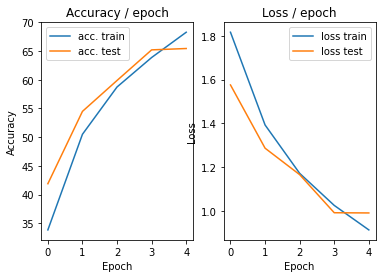

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.212s (0.212s)	Loss 0.8806 (0.8806)	Prec@1  71.1 ( 71.1)	Prec@5  99.2 ( 99.2)


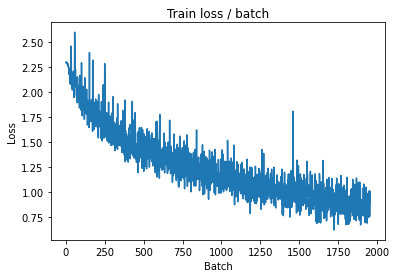

[TRAIN Batch 200/391]	Time 0.023s (0.056s)	Loss 0.6182 (0.8374)	Prec@1  78.1 ( 70.9)	Prec@5  99.2 ( 97.8)


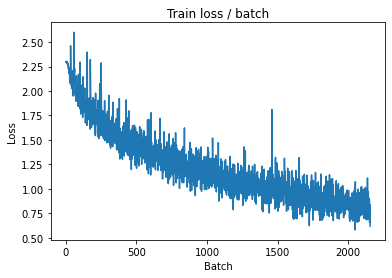


===============> Total time 21s	Avg loss 0.8307	Avg Prec@1 71.16 %	Avg Prec@5 97.75 %

[EVAL Batch 000/079]	Time 0.153s (0.153s)	Loss 0.8236 (0.8236)	Prec@1  69.5 ( 69.5)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.8810	Avg Prec@1 69.66 %	Avg Prec@5 97.50 %



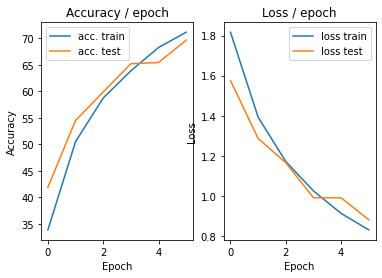

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.235s (0.235s)	Loss 0.8517 (0.8517)	Prec@1  70.3 ( 70.3)	Prec@5  99.2 ( 99.2)


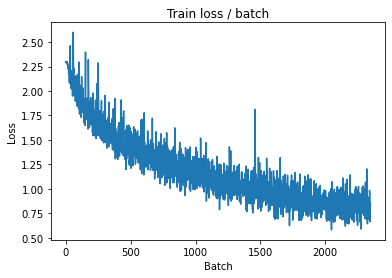

[TRAIN Batch 200/391]	Time 0.093s (0.057s)	Loss 0.7790 (0.7688)	Prec@1  73.4 ( 73.3)	Prec@5  96.9 ( 98.2)


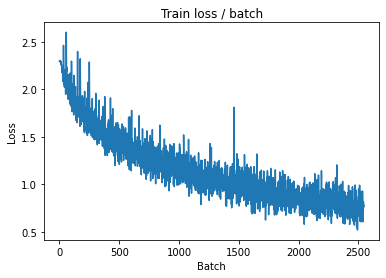


===============> Total time 22s	Avg loss 0.7566	Avg Prec@1 73.65 %	Avg Prec@5 98.22 %

[EVAL Batch 000/079]	Time 0.162s (0.162s)	Loss 0.7170 (0.7170)	Prec@1  78.9 ( 78.9)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.8395	Avg Prec@1 70.76 %	Avg Prec@5 97.74 %



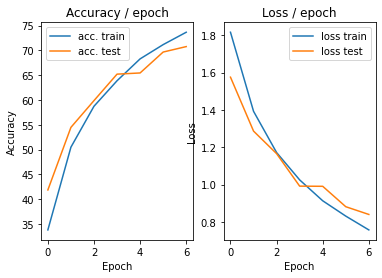

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.224s (0.224s)	Loss 0.7273 (0.7273)	Prec@1  73.4 ( 73.4)	Prec@5  99.2 ( 99.2)


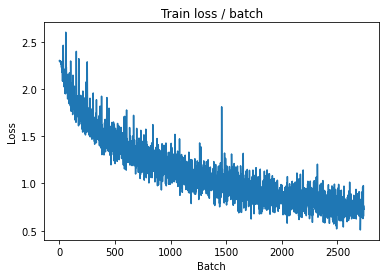

[TRAIN Batch 200/391]	Time 0.095s (0.056s)	Loss 0.7984 (0.7202)	Prec@1  71.9 ( 74.8)	Prec@5 100.0 ( 98.4)


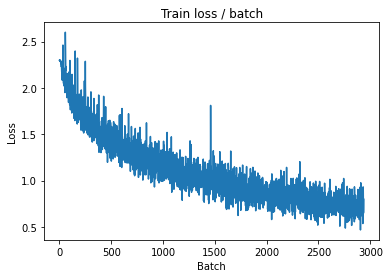


===============> Total time 21s	Avg loss 0.7082	Avg Prec@1 75.24 %	Avg Prec@5 98.41 %

[EVAL Batch 000/079]	Time 0.158s (0.158s)	Loss 0.7896 (0.7896)	Prec@1  75.8 ( 75.8)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.8068	Avg Prec@1 72.64 %	Avg Prec@5 98.01 %



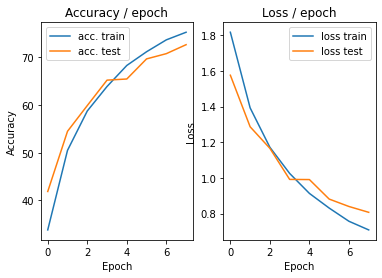

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.220s (0.220s)	Loss 0.7157 (0.7157)	Prec@1  72.7 ( 72.7)	Prec@5  98.4 ( 98.4)


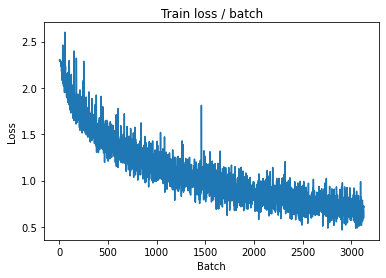

[TRAIN Batch 200/391]	Time 0.025s (0.056s)	Loss 0.7141 (0.6662)	Prec@1  77.3 ( 76.6)	Prec@5  99.2 ( 98.7)


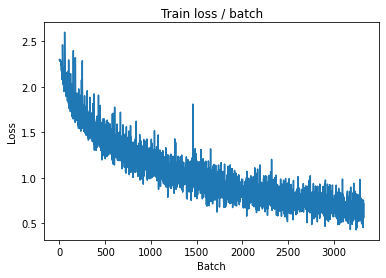


===============> Total time 21s	Avg loss 0.6698	Avg Prec@1 76.49 %	Avg Prec@5 98.67 %

[EVAL Batch 000/079]	Time 0.160s (0.160s)	Loss 0.8407 (0.8407)	Prec@1  68.8 ( 68.8)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.8605	Avg Prec@1 70.67 %	Avg Prec@5 97.73 %



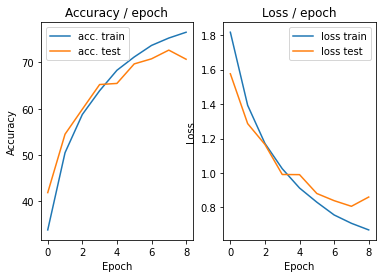

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.220s (0.220s)	Loss 0.7182 (0.7182)	Prec@1  75.0 ( 75.0)	Prec@5  98.4 ( 98.4)


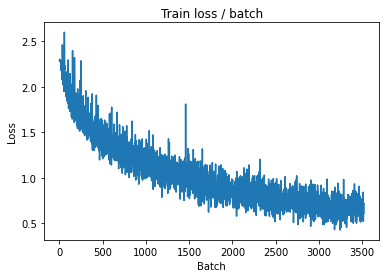

[TRAIN Batch 200/391]	Time 0.019s (0.057s)	Loss 0.6514 (0.6266)	Prec@1  78.9 ( 78.0)	Prec@5  98.4 ( 98.7)


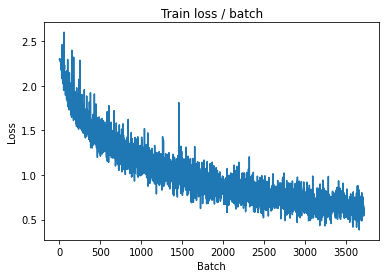


===============> Total time 21s	Avg loss 0.6262	Avg Prec@1 78.11 %	Avg Prec@5 98.79 %

[EVAL Batch 000/079]	Time 0.154s (0.154s)	Loss 0.6439 (0.6439)	Prec@1  77.3 ( 77.3)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.7300	Avg Prec@1 75.24 %	Avg Prec@5 98.24 %



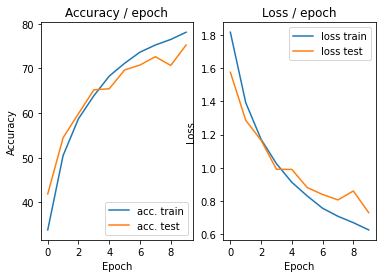

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.211s (0.211s)	Loss 0.5049 (0.5049)	Prec@1  83.6 ( 83.6)	Prec@5 100.0 (100.0)


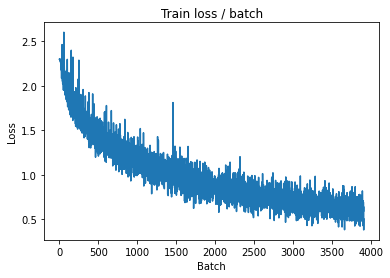

[TRAIN Batch 200/391]	Time 0.071s (0.057s)	Loss 0.7191 (0.5940)	Prec@1  77.3 ( 79.3)	Prec@5  99.2 ( 99.0)


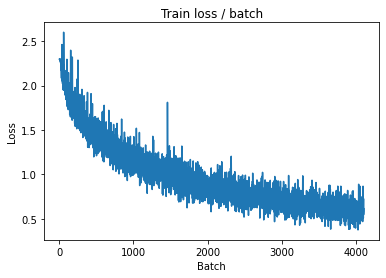


===============> Total time 21s	Avg loss 0.5878	Avg Prec@1 79.52 %	Avg Prec@5 98.99 %

[EVAL Batch 000/079]	Time 0.148s (0.148s)	Loss 0.6934 (0.6934)	Prec@1  79.7 ( 79.7)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.7668	Avg Prec@1 74.20 %	Avg Prec@5 98.10 %



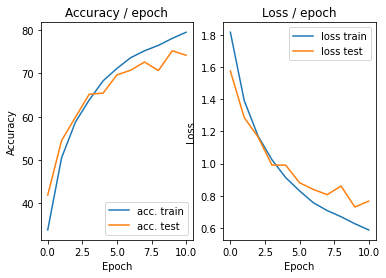

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.215s (0.215s)	Loss 0.7875 (0.7875)	Prec@1  74.2 ( 74.2)	Prec@5  98.4 ( 98.4)


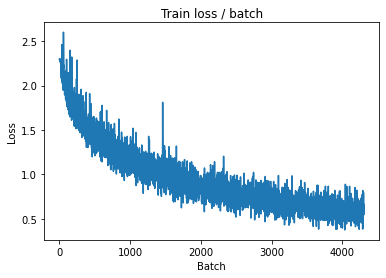

[TRAIN Batch 200/391]	Time 0.026s (0.056s)	Loss 0.5528 (0.5541)	Prec@1  82.0 ( 80.9)	Prec@5  99.2 ( 99.0)


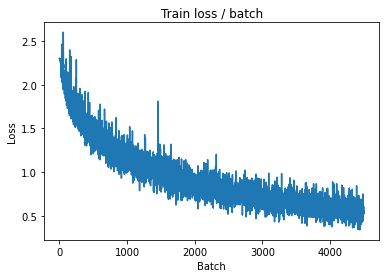


===============> Total time 21s	Avg loss 0.5573	Avg Prec@1 80.59 %	Avg Prec@5 98.99 %

[EVAL Batch 000/079]	Time 0.153s (0.153s)	Loss 0.8018 (0.8018)	Prec@1  75.8 ( 75.8)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 0.7941	Avg Prec@1 73.54 %	Avg Prec@5 98.14 %



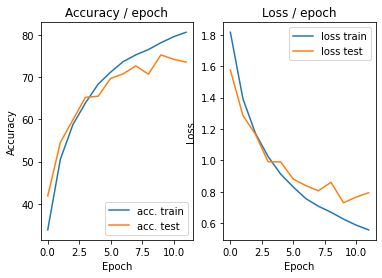

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.202s (0.202s)	Loss 0.5864 (0.5864)	Prec@1  75.0 ( 75.0)	Prec@5 100.0 (100.0)


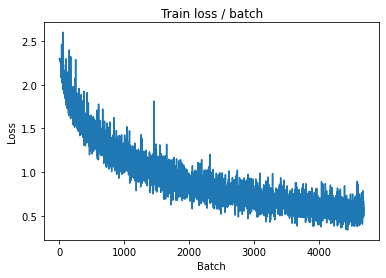

[TRAIN Batch 200/391]	Time 0.044s (0.056s)	Loss 0.5833 (0.5267)	Prec@1  82.0 ( 81.6)	Prec@5  98.4 ( 99.2)


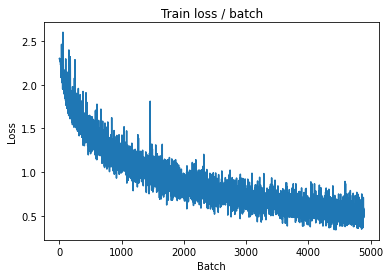


===============> Total time 21s	Avg loss 0.5303	Avg Prec@1 81.56 %	Avg Prec@5 99.20 %

[EVAL Batch 000/079]	Time 0.160s (0.160s)	Loss 0.7150 (0.7150)	Prec@1  75.8 ( 75.8)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.7435	Avg Prec@1 74.75 %	Avg Prec@5 98.12 %



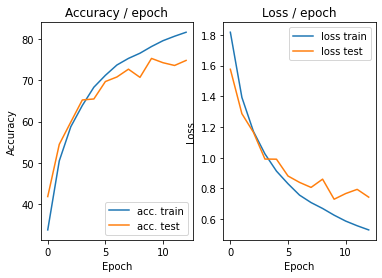

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.214s (0.214s)	Loss 0.6531 (0.6531)	Prec@1  76.6 ( 76.6)	Prec@5 100.0 (100.0)


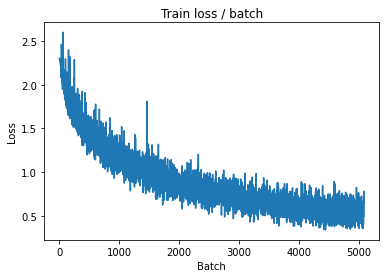

[TRAIN Batch 200/391]	Time 0.044s (0.056s)	Loss 0.4454 (0.5065)	Prec@1  82.0 ( 82.5)	Prec@5 100.0 ( 99.3)


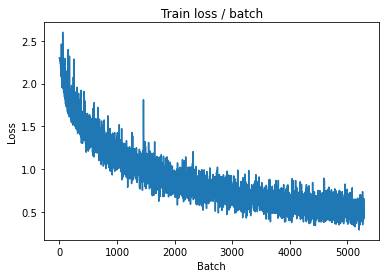


===============> Total time 21s	Avg loss 0.5065	Avg Prec@1 82.37 %	Avg Prec@5 99.30 %

[EVAL Batch 000/079]	Time 0.157s (0.157s)	Loss 0.8085 (0.8085)	Prec@1  75.8 ( 75.8)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.8046	Avg Prec@1 72.80 %	Avg Prec@5 98.30 %



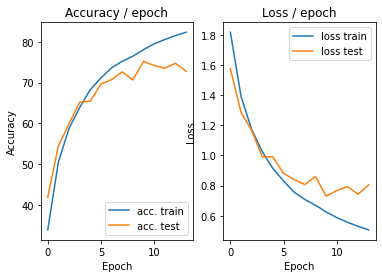

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.210s (0.210s)	Loss 0.4653 (0.4653)	Prec@1  86.7 ( 86.7)	Prec@5  98.4 ( 98.4)


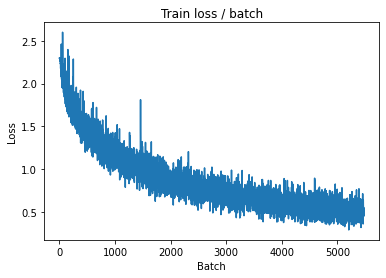

[TRAIN Batch 200/391]	Time 0.067s (0.057s)	Loss 0.4753 (0.4710)	Prec@1  84.4 ( 83.3)	Prec@5 100.0 ( 99.4)


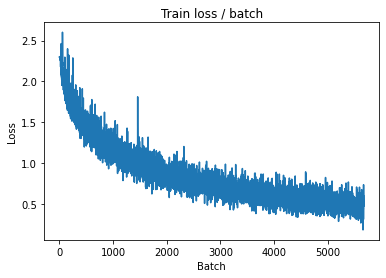


===============> Total time 21s	Avg loss 0.4812	Avg Prec@1 83.15 %	Avg Prec@5 99.35 %

[EVAL Batch 000/079]	Time 0.174s (0.174s)	Loss 0.6973 (0.6973)	Prec@1  80.5 ( 80.5)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.7312	Avg Prec@1 75.97 %	Avg Prec@5 98.36 %



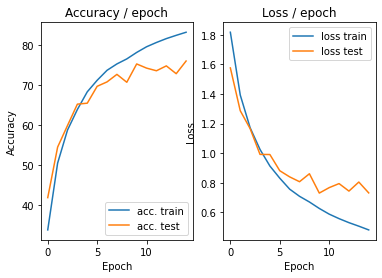

In [24]:
main4(128, 0.1, epochs=15 ,cuda=True)

### 3.3 Variantes sur l’algorithme d’optimisation
#### d'abord avec un momentum seul sans schedular

In [31]:
class ConvNet5(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet5, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv

        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input

        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201]),
            transforms.RandomCrop(28),
            transforms.RandomHorizontalFlip(),
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201]),
            transforms.CenterCrop(28),
 
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss

def main5(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet5()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
    # lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.221s (0.221s)	Loss 2.2979 (2.2979)	Prec@1  11.7 ( 11.7)	Prec@5  55.5 ( 55.5)


<Figure size 432x288 with 0 Axes>

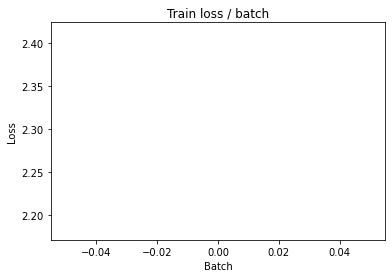

[TRAIN Batch 200/391]	Time 0.096s (0.056s)	Loss 2.0539 (1.9497)	Prec@1  28.1 ( 28.4)	Prec@5  78.1 ( 80.1)


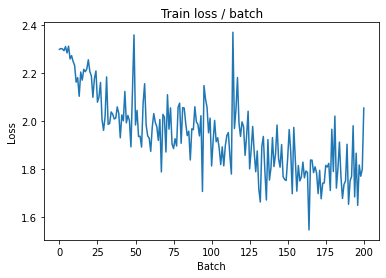


===============> Total time 21s	Avg loss 1.8331	Avg Prec@1 32.90 %	Avg Prec@5 84.00 %

[EVAL Batch 000/079]	Time 0.170s (0.170s)	Loss 1.8243 (1.8243)	Prec@1  35.9 ( 35.9)	Prec@5  85.2 ( 85.2)

===============> Total time 2s	Avg loss 1.7390	Avg Prec@1 36.82 %	Avg Prec@5 88.19 %



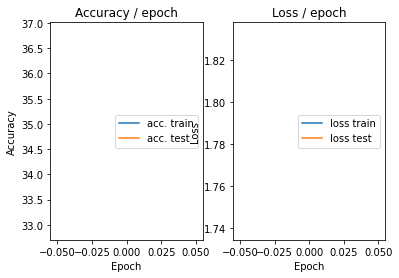

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.213s (0.213s)	Loss 1.6966 (1.6966)	Prec@1  36.7 ( 36.7)	Prec@5  87.5 ( 87.5)


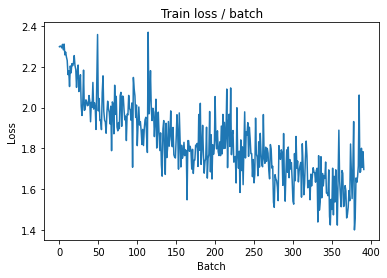

[TRAIN Batch 200/391]	Time 0.068s (0.056s)	Loss 1.5876 (1.6289)	Prec@1  48.4 ( 40.6)	Prec@5  90.6 ( 89.6)


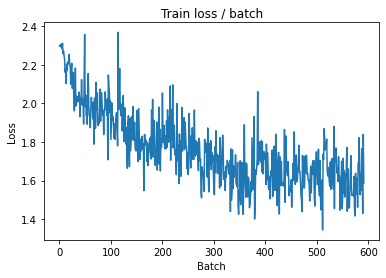


===============> Total time 21s	Avg loss 1.6192	Avg Prec@1 41.36 %	Avg Prec@5 89.64 %

[EVAL Batch 000/079]	Time 0.169s (0.169s)	Loss 1.4677 (1.4677)	Prec@1  50.8 ( 50.8)	Prec@5  89.8 ( 89.8)

===============> Total time 2s	Avg loss 1.5507	Avg Prec@1 45.84 %	Avg Prec@5 90.47 %



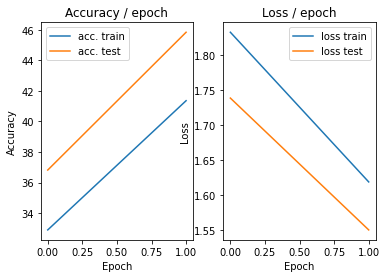

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.206s (0.206s)	Loss 1.4472 (1.4472)	Prec@1  47.7 ( 47.7)	Prec@5  90.6 ( 90.6)


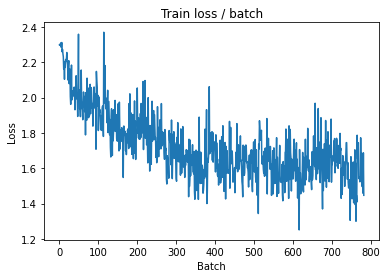

[TRAIN Batch 200/391]	Time 0.021s (0.056s)	Loss 1.5894 (1.5889)	Prec@1  46.1 ( 43.1)	Prec@5  86.7 ( 89.8)


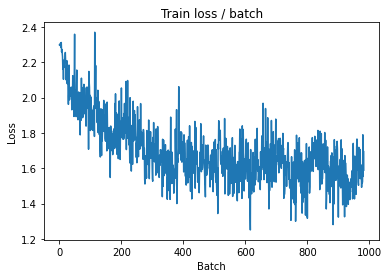


===============> Total time 21s	Avg loss 1.5832	Avg Prec@1 43.48 %	Avg Prec@5 90.12 %

[EVAL Batch 000/079]	Time 0.176s (0.176s)	Loss 1.6291 (1.6291)	Prec@1  47.7 ( 47.7)	Prec@5  92.2 ( 92.2)

===============> Total time 2s	Avg loss 1.5033	Avg Prec@1 46.78 %	Avg Prec@5 91.81 %



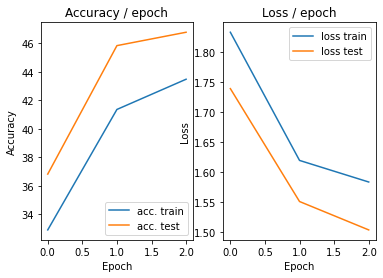

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.222s (0.222s)	Loss 1.5230 (1.5230)	Prec@1  40.6 ( 40.6)	Prec@5  89.8 ( 89.8)


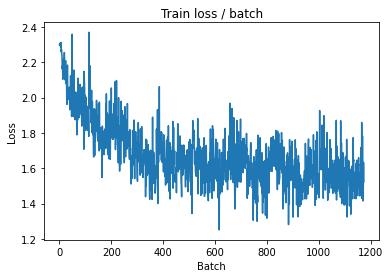

[TRAIN Batch 200/391]	Time 0.094s (0.056s)	Loss 1.6568 (1.5560)	Prec@1  40.6 ( 45.2)	Prec@5  92.2 ( 90.5)


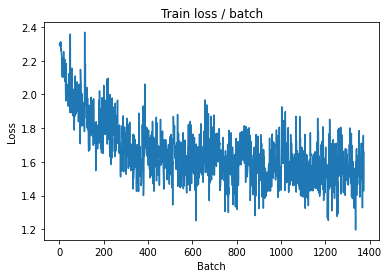


===============> Total time 21s	Avg loss 1.5491	Avg Prec@1 45.33 %	Avg Prec@5 90.57 %

[EVAL Batch 000/079]	Time 0.171s (0.171s)	Loss 1.6256 (1.6256)	Prec@1  50.0 ( 50.0)	Prec@5  90.6 ( 90.6)

===============> Total time 2s	Avg loss 1.5529	Avg Prec@1 46.98 %	Avg Prec@5 90.89 %



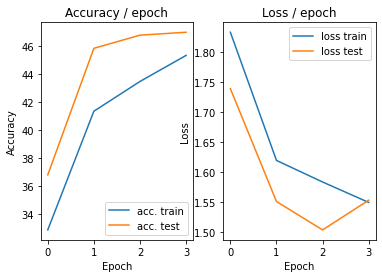

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.214s (0.214s)	Loss 1.4868 (1.4868)	Prec@1  46.9 ( 46.9)	Prec@5  92.2 ( 92.2)


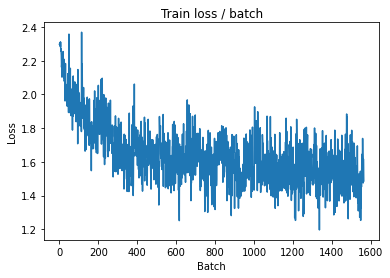

[TRAIN Batch 200/391]	Time 0.088s (0.057s)	Loss 1.5858 (1.5756)	Prec@1  48.4 ( 45.0)	Prec@5  91.4 ( 89.6)


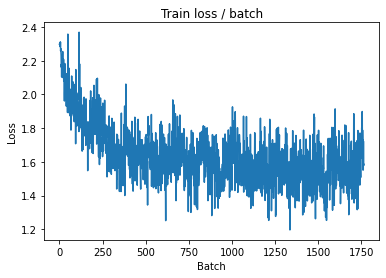


===============> Total time 21s	Avg loss 1.5772	Avg Prec@1 45.09 %	Avg Prec@5 89.77 %

[EVAL Batch 000/079]	Time 0.172s (0.172s)	Loss 1.6325 (1.6325)	Prec@1  44.5 ( 44.5)	Prec@5  84.4 ( 84.4)

===============> Total time 2s	Avg loss 1.6086	Avg Prec@1 43.18 %	Avg Prec@5 89.03 %



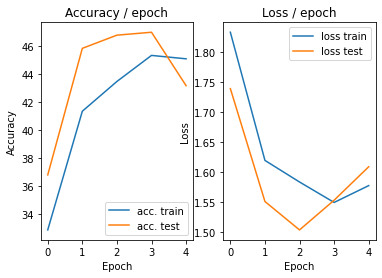

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.214s (0.214s)	Loss 1.6433 (1.6433)	Prec@1  39.1 ( 39.1)	Prec@5  86.7 ( 86.7)


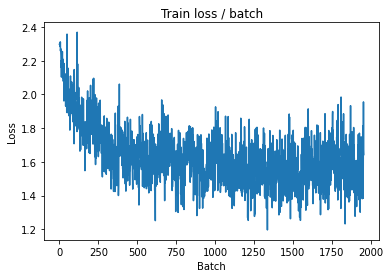

[TRAIN Batch 200/391]	Time 0.037s (0.056s)	Loss 1.4011 (1.5524)	Prec@1  50.0 ( 46.5)	Prec@5  93.8 ( 90.1)


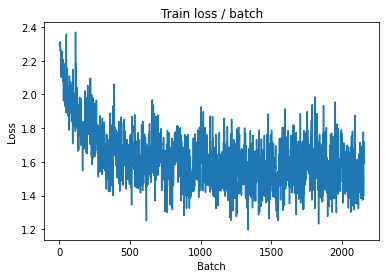


===============> Total time 21s	Avg loss 1.5474	Avg Prec@1 46.46 %	Avg Prec@5 90.19 %

[EVAL Batch 000/079]	Time 0.176s (0.176s)	Loss 1.4765 (1.4765)	Prec@1  48.4 ( 48.4)	Prec@5  91.4 ( 91.4)

===============> Total time 2s	Avg loss 1.4876	Avg Prec@1 48.44 %	Avg Prec@5 91.46 %



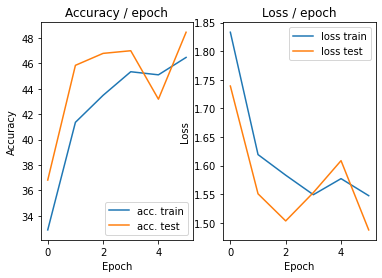

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.215s (0.215s)	Loss 1.3983 (1.3983)	Prec@1  50.8 ( 50.8)	Prec@5  93.0 ( 93.0)


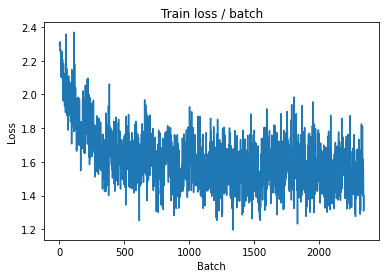

[TRAIN Batch 200/391]	Time 0.080s (0.056s)	Loss 1.5146 (1.5660)	Prec@1  45.3 ( 45.9)	Prec@5  88.3 ( 89.8)


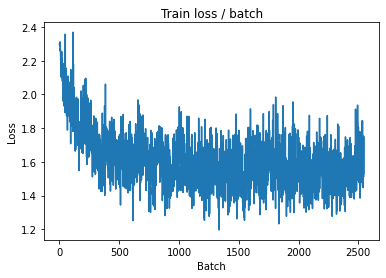


===============> Total time 21s	Avg loss 1.5818	Avg Prec@1 45.27 %	Avg Prec@5 89.55 %

[EVAL Batch 000/079]	Time 0.170s (0.170s)	Loss 1.6682 (1.6682)	Prec@1  47.7 ( 47.7)	Prec@5  87.5 ( 87.5)

===============> Total time 2s	Avg loss 1.5708	Avg Prec@1 45.85 %	Avg Prec@5 90.34 %



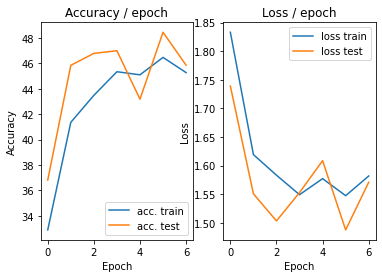

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.229s (0.229s)	Loss 1.5737 (1.5737)	Prec@1  45.3 ( 45.3)	Prec@5  85.2 ( 85.2)


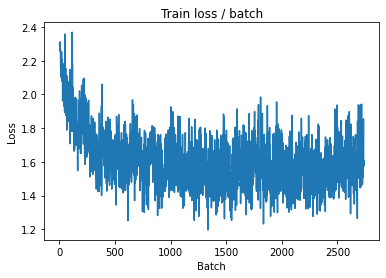

[TRAIN Batch 200/391]	Time 0.030s (0.056s)	Loss 1.5957 (1.5810)	Prec@1  45.3 ( 45.7)	Prec@5  90.6 ( 89.6)


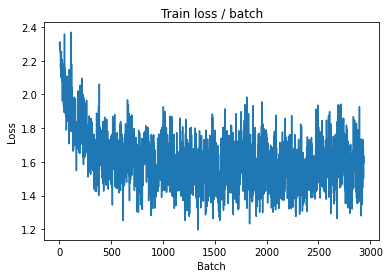


===============> Total time 21s	Avg loss 1.5487	Avg Prec@1 46.51 %	Avg Prec@5 90.09 %

[EVAL Batch 000/079]	Time 0.166s (0.166s)	Loss 1.6163 (1.6163)	Prec@1  45.3 ( 45.3)	Prec@5  89.8 ( 89.8)

===============> Total time 2s	Avg loss 1.4951	Avg Prec@1 47.84 %	Avg Prec@5 91.35 %



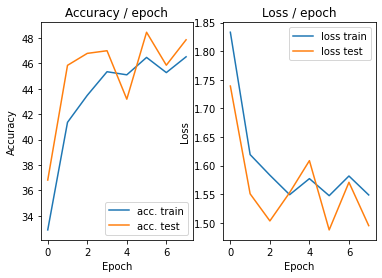

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.224s (0.224s)	Loss 1.4062 (1.4062)	Prec@1  46.1 ( 46.1)	Prec@5  92.2 ( 92.2)


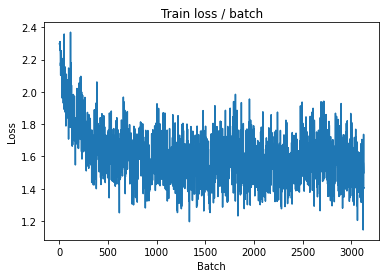

[TRAIN Batch 200/391]	Time 0.020s (0.057s)	Loss 1.5004 (1.5650)	Prec@1  47.7 ( 46.0)	Prec@5  86.7 ( 89.6)


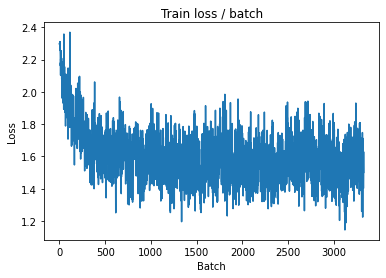


===============> Total time 22s	Avg loss 1.5622	Avg Prec@1 46.12 %	Avg Prec@5 89.62 %

[EVAL Batch 000/079]	Time 0.177s (0.177s)	Loss 1.6211 (1.6211)	Prec@1  46.9 ( 46.9)	Prec@5  89.8 ( 89.8)

===============> Total time 2s	Avg loss 1.5202	Avg Prec@1 48.71 %	Avg Prec@5 91.03 %



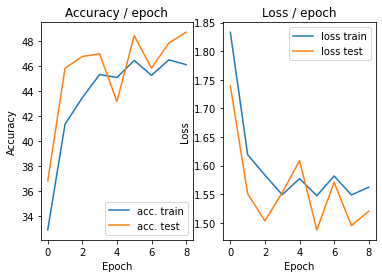

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.253s (0.253s)	Loss 1.4465 (1.4465)	Prec@1  52.3 ( 52.3)	Prec@5  90.6 ( 90.6)


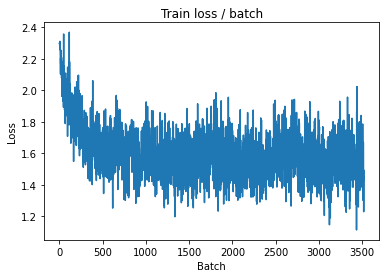

[TRAIN Batch 200/391]	Time 0.107s (0.057s)	Loss 1.6422 (1.5857)	Prec@1  43.0 ( 45.1)	Prec@5  92.2 ( 89.3)


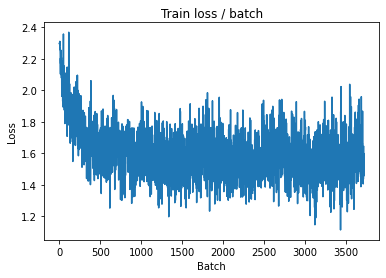


===============> Total time 21s	Avg loss 1.5802	Avg Prec@1 45.41 %	Avg Prec@5 89.27 %

[EVAL Batch 000/079]	Time 0.167s (0.167s)	Loss 1.9144 (1.9144)	Prec@1  39.8 ( 39.8)	Prec@5  82.8 ( 82.8)

===============> Total time 3s	Avg loss 1.6520	Avg Prec@1 45.61 %	Avg Prec@5 89.10 %



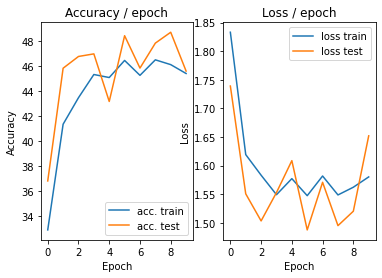

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.219s (0.219s)	Loss 1.8417 (1.8417)	Prec@1  42.2 ( 42.2)	Prec@5  84.4 ( 84.4)


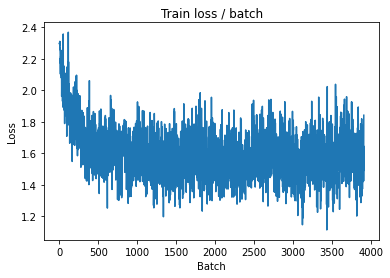

[TRAIN Batch 200/391]	Time 0.079s (0.056s)	Loss 1.4044 (1.5809)	Prec@1  46.9 ( 45.4)	Prec@5  89.8 ( 89.5)


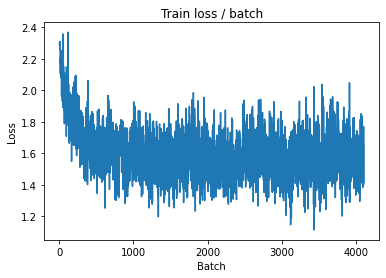


===============> Total time 21s	Avg loss 1.5784	Avg Prec@1 45.70 %	Avg Prec@5 89.53 %

[EVAL Batch 000/079]	Time 0.172s (0.172s)	Loss 1.6652 (1.6652)	Prec@1  40.6 ( 40.6)	Prec@5  89.8 ( 89.8)

===============> Total time 2s	Avg loss 1.5759	Avg Prec@1 45.53 %	Avg Prec@5 89.36 %



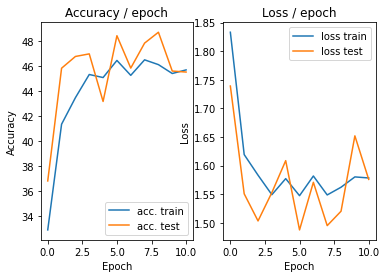

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.211s (0.211s)	Loss 1.5579 (1.5579)	Prec@1  52.3 ( 52.3)	Prec@5  89.8 ( 89.8)


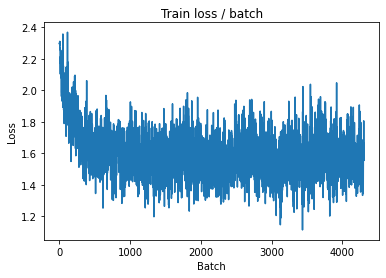

[TRAIN Batch 200/391]	Time 0.024s (0.056s)	Loss 1.5802 (1.5734)	Prec@1  47.7 ( 46.6)	Prec@5  84.4 ( 89.2)


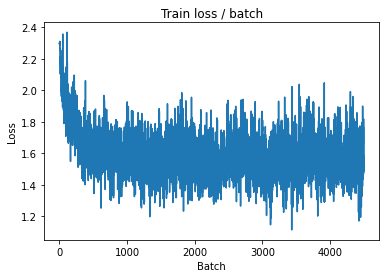


===============> Total time 21s	Avg loss 1.5900	Avg Prec@1 45.69 %	Avg Prec@5 88.81 %

[EVAL Batch 000/079]	Time 0.170s (0.170s)	Loss 1.7347 (1.7347)	Prec@1  43.0 ( 43.0)	Prec@5  82.0 ( 82.0)

===============> Total time 2s	Avg loss 1.5675	Avg Prec@1 46.13 %	Avg Prec@5 88.97 %



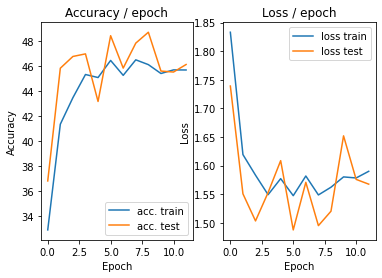

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.221s (0.221s)	Loss 1.5900 (1.5900)	Prec@1  47.7 ( 47.7)	Prec@5  89.1 ( 89.1)


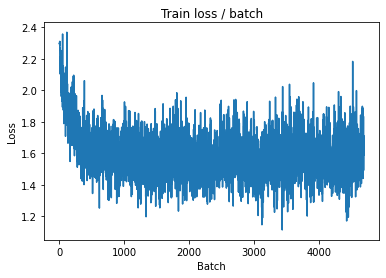

[TRAIN Batch 200/391]	Time 0.019s (0.056s)	Loss 1.3964 (1.6176)	Prec@1  53.9 ( 44.6)	Prec@5  89.8 ( 88.4)


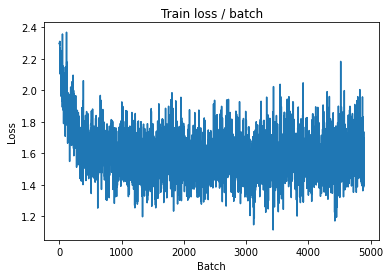


===============> Total time 21s	Avg loss 1.6140	Avg Prec@1 44.86 %	Avg Prec@5 88.56 %

[EVAL Batch 000/079]	Time 0.160s (0.160s)	Loss 1.6560 (1.6560)	Prec@1  39.8 ( 39.8)	Prec@5  85.2 ( 85.2)

===============> Total time 2s	Avg loss 1.6440	Avg Prec@1 43.61 %	Avg Prec@5 87.84 %



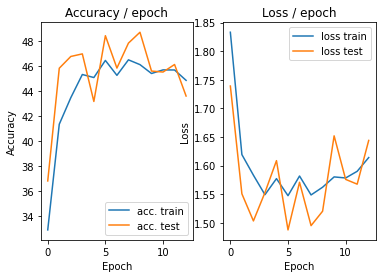

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.255s (0.255s)	Loss 1.5702 (1.5702)	Prec@1  46.9 ( 46.9)	Prec@5  86.7 ( 86.7)


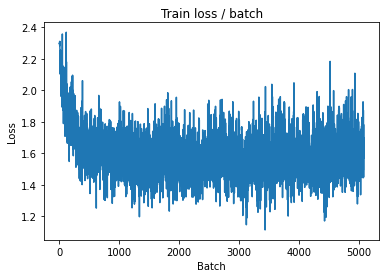

[TRAIN Batch 200/391]	Time 0.028s (0.058s)	Loss 1.5322 (1.5807)	Prec@1  43.8 ( 45.7)	Prec@5  89.8 ( 89.2)


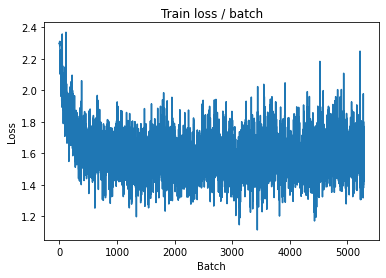


===============> Total time 22s	Avg loss 1.5793	Avg Prec@1 45.96 %	Avg Prec@5 89.09 %

[EVAL Batch 000/079]	Time 0.176s (0.176s)	Loss 1.5419 (1.5419)	Prec@1  50.8 ( 50.8)	Prec@5  86.7 ( 86.7)

===============> Total time 3s	Avg loss 1.5566	Avg Prec@1 47.40 %	Avg Prec@5 89.11 %



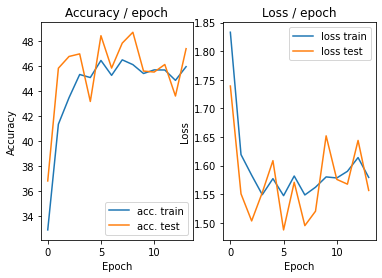

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.227s (0.227s)	Loss 1.3576 (1.3576)	Prec@1  50.8 ( 50.8)	Prec@5  93.0 ( 93.0)


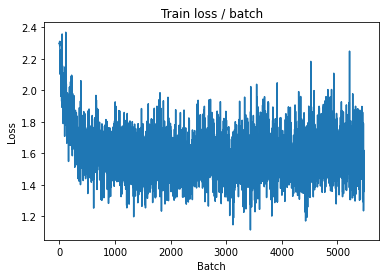

[TRAIN Batch 200/391]	Time 0.067s (0.056s)	Loss 1.4025 (1.5710)	Prec@1  48.4 ( 46.2)	Prec@5  85.2 ( 89.3)


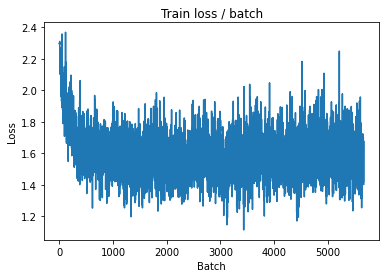


===============> Total time 21s	Avg loss 1.5785	Avg Prec@1 46.04 %	Avg Prec@5 89.23 %

[EVAL Batch 000/079]	Time 0.170s (0.170s)	Loss 1.5235 (1.5235)	Prec@1  48.4 ( 48.4)	Prec@5  88.3 ( 88.3)

===============> Total time 2s	Avg loss 1.5611	Avg Prec@1 45.51 %	Avg Prec@5 89.22 %



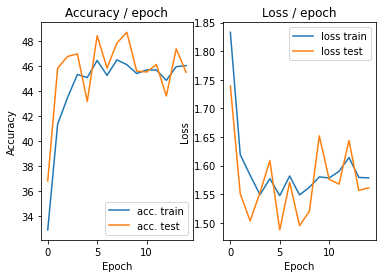

In [32]:
main5(128, 0.1, epochs=15 ,cuda=True)

#### avec décroissance exponentielle (learning rate schedular)

In [33]:
class ConvNet6(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet6, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv

        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input

        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201]),
            transforms.RandomCrop(28),
            transforms.RandomHorizontalFlip(),
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201]),
            transforms.CenterCrop(28),
 
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss

def main6(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet6()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
    lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

        lr_sched.step()

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.214s (0.214s)	Loss 2.2964 (2.2964)	Prec@1  14.8 ( 14.8)	Prec@5  57.8 ( 57.8)


<Figure size 432x288 with 0 Axes>

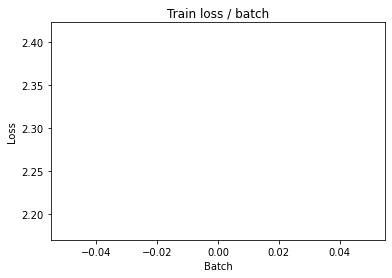

[TRAIN Batch 200/391]	Time 0.094s (0.056s)	Loss 1.8103 (2.0486)	Prec@1  27.3 ( 24.2)	Prec@5  85.2 ( 75.4)


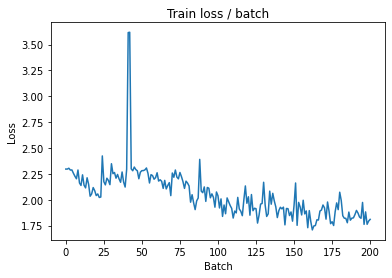


===============> Total time 21s	Avg loss 1.9230	Avg Prec@1 28.95 %	Avg Prec@5 80.68 %

[EVAL Batch 000/079]	Time 0.174s (0.174s)	Loss 1.6554 (1.6554)	Prec@1  45.3 ( 45.3)	Prec@5  89.1 ( 89.1)

===============> Total time 2s	Avg loss 1.6970	Avg Prec@1 37.01 %	Avg Prec@5 89.34 %



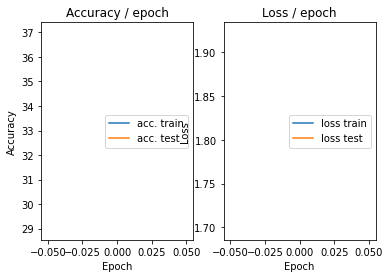

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.212s (0.212s)	Loss 1.6449 (1.6449)	Prec@1  40.6 ( 40.6)	Prec@5  89.1 ( 89.1)


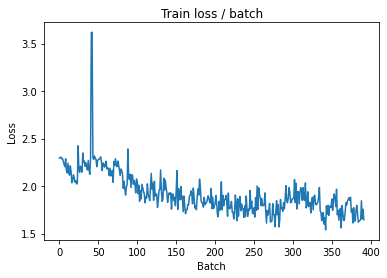

[TRAIN Batch 200/391]	Time 0.097s (0.056s)	Loss 1.6735 (1.7100)	Prec@1  37.5 ( 37.1)	Prec@5  89.8 ( 88.1)


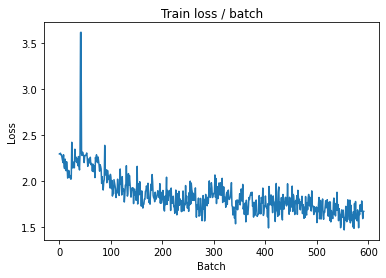


===============> Total time 21s	Avg loss 1.6853	Avg Prec@1 38.25 %	Avg Prec@5 88.58 %

[EVAL Batch 000/079]	Time 0.171s (0.171s)	Loss 1.4539 (1.4539)	Prec@1  46.9 ( 46.9)	Prec@5  93.8 ( 93.8)

===============> Total time 2s	Avg loss 1.5567	Avg Prec@1 42.46 %	Avg Prec@5 91.24 %



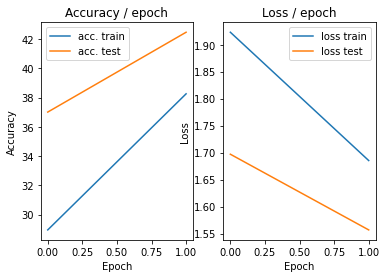

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.220s (0.220s)	Loss 1.4707 (1.4707)	Prec@1  43.8 ( 43.8)	Prec@5  95.3 ( 95.3)


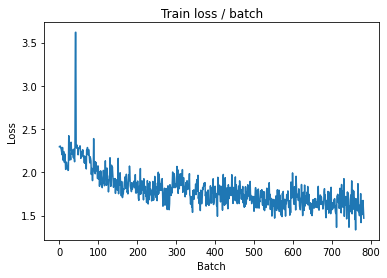

[TRAIN Batch 200/391]	Time 0.088s (0.056s)	Loss 1.4217 (1.6279)	Prec@1  48.4 ( 41.1)	Prec@5  92.2 ( 89.4)


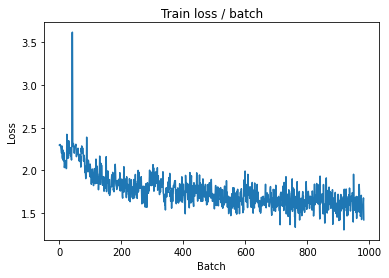


===============> Total time 21s	Avg loss 1.6010	Avg Prec@1 42.20 %	Avg Prec@5 89.90 %

[EVAL Batch 000/079]	Time 0.154s (0.154s)	Loss 1.5858 (1.5858)	Prec@1  45.3 ( 45.3)	Prec@5  93.0 ( 93.0)

===============> Total time 2s	Avg loss 1.5768	Avg Prec@1 43.32 %	Avg Prec@5 90.55 %



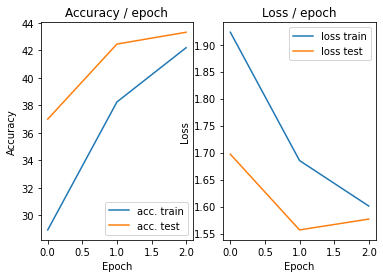

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.222s (0.222s)	Loss 1.5586 (1.5586)	Prec@1  45.3 ( 45.3)	Prec@5  91.4 ( 91.4)


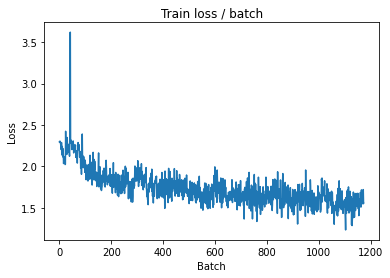

[TRAIN Batch 200/391]	Time 0.026s (0.056s)	Loss 1.5228 (1.5316)	Prec@1  45.3 ( 45.1)	Prec@5  90.6 ( 90.7)


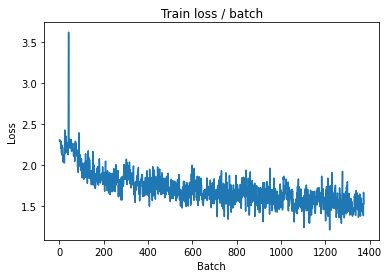


===============> Total time 21s	Avg loss 1.5141	Avg Prec@1 45.98 %	Avg Prec@5 91.04 %

[EVAL Batch 000/079]	Time 0.161s (0.161s)	Loss 1.5625 (1.5625)	Prec@1  46.9 ( 46.9)	Prec@5  93.8 ( 93.8)

===============> Total time 2s	Avg loss 1.4492	Avg Prec@1 49.36 %	Avg Prec@5 92.26 %



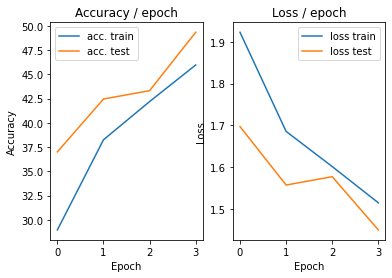

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.211s (0.211s)	Loss 1.3516 (1.3516)	Prec@1  56.2 ( 56.2)	Prec@5  94.5 ( 94.5)


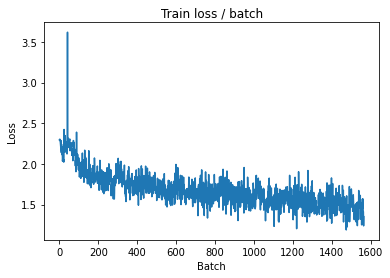

[TRAIN Batch 200/391]	Time 0.066s (0.057s)	Loss 1.7728 (1.4772)	Prec@1  40.6 ( 47.7)	Prec@5  87.5 ( 91.9)


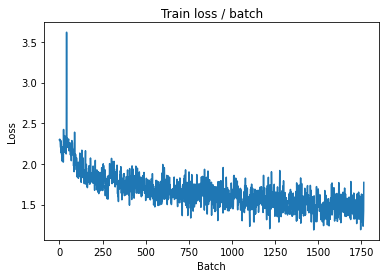


===============> Total time 22s	Avg loss 1.4510	Avg Prec@1 48.91 %	Avg Prec@5 92.20 %

[EVAL Batch 000/079]	Time 0.189s (0.189s)	Loss 1.2783 (1.2783)	Prec@1  51.6 ( 51.6)	Prec@5  91.4 ( 91.4)

===============> Total time 2s	Avg loss 1.3545	Avg Prec@1 53.35 %	Avg Prec@5 92.85 %



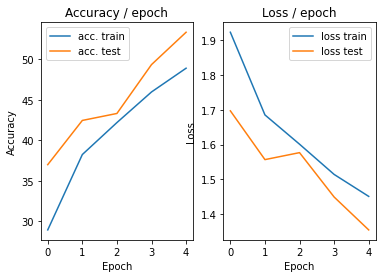

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.215s (0.215s)	Loss 1.3518 (1.3518)	Prec@1  52.3 ( 52.3)	Prec@5  91.4 ( 91.4)


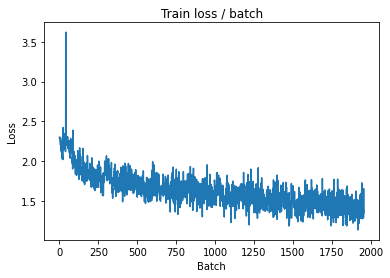

[TRAIN Batch 200/391]	Time 0.037s (0.056s)	Loss 1.2161 (1.4037)	Prec@1  60.2 ( 51.6)	Prec@5  94.5 ( 92.3)


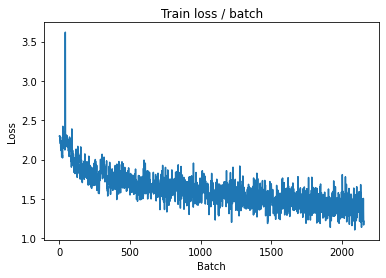


===============> Total time 21s	Avg loss 1.4006	Avg Prec@1 51.68 %	Avg Prec@5 92.34 %

[EVAL Batch 000/079]	Time 0.174s (0.174s)	Loss 1.3612 (1.3612)	Prec@1  53.1 ( 53.1)	Prec@5  93.8 ( 93.8)

===============> Total time 2s	Avg loss 1.3508	Avg Prec@1 52.97 %	Avg Prec@5 92.75 %



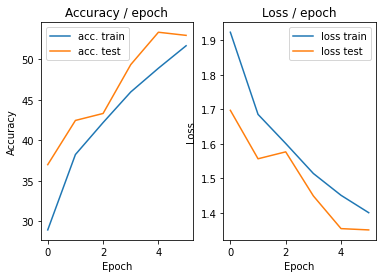

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.217s (0.217s)	Loss 1.3109 (1.3109)	Prec@1  55.5 ( 55.5)	Prec@5  95.3 ( 95.3)


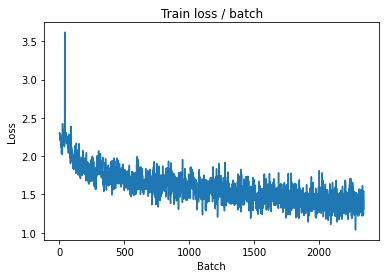

[TRAIN Batch 200/391]	Time 0.091s (0.057s)	Loss 1.3859 (1.3497)	Prec@1  54.7 ( 53.3)	Prec@5  95.3 ( 92.9)


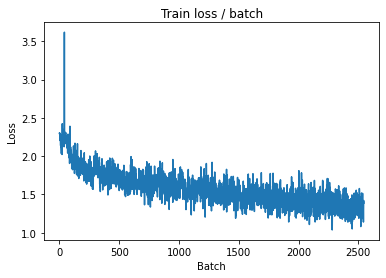


===============> Total time 21s	Avg loss 1.3586	Avg Prec@1 52.96 %	Avg Prec@5 92.82 %

[EVAL Batch 000/079]	Time 0.175s (0.175s)	Loss 1.3181 (1.3181)	Prec@1  53.1 ( 53.1)	Prec@5  93.0 ( 93.0)

===============> Total time 2s	Avg loss 1.2694	Avg Prec@1 56.44 %	Avg Prec@5 93.73 %



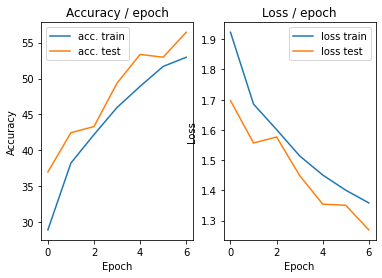

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.207s (0.207s)	Loss 1.1414 (1.1414)	Prec@1  57.0 ( 57.0)	Prec@5  93.0 ( 93.0)


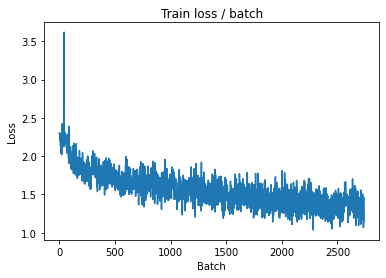

[TRAIN Batch 200/391]	Time 0.026s (0.058s)	Loss 1.3996 (1.3364)	Prec@1  54.7 ( 54.2)	Prec@5  91.4 ( 92.9)


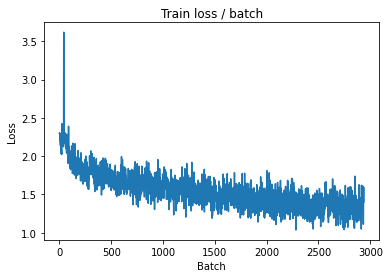


===============> Total time 22s	Avg loss 1.3232	Avg Prec@1 54.48 %	Avg Prec@5 93.16 %

[EVAL Batch 000/079]	Time 0.183s (0.183s)	Loss 1.2788 (1.2788)	Prec@1  62.5 ( 62.5)	Prec@5  91.4 ( 91.4)

===============> Total time 2s	Avg loss 1.2551	Avg Prec@1 58.20 %	Avg Prec@5 94.24 %



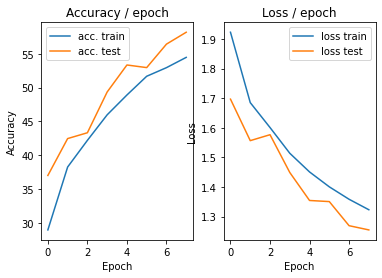

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.214s (0.214s)	Loss 1.2246 (1.2246)	Prec@1  54.7 ( 54.7)	Prec@5  95.3 ( 95.3)


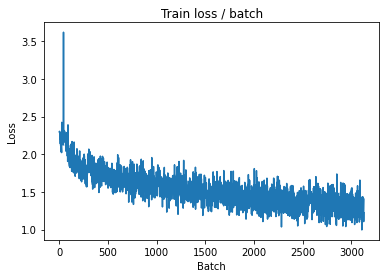

[TRAIN Batch 200/391]	Time 0.020s (0.057s)	Loss 1.2890 (1.2688)	Prec@1  53.9 ( 56.1)	Prec@5  93.0 ( 93.8)


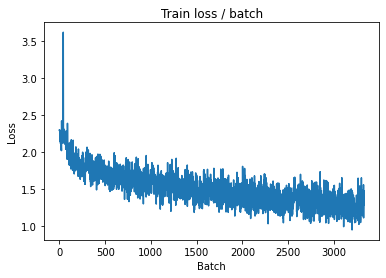


===============> Total time 21s	Avg loss 1.2728	Avg Prec@1 56.10 %	Avg Prec@5 93.79 %

[EVAL Batch 000/079]	Time 0.181s (0.181s)	Loss 1.2702 (1.2702)	Prec@1  60.9 ( 60.9)	Prec@5  91.4 ( 91.4)

===============> Total time 3s	Avg loss 1.2850	Avg Prec@1 56.50 %	Avg Prec@5 93.65 %



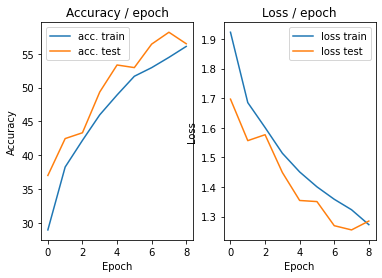

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.226s (0.226s)	Loss 1.2563 (1.2563)	Prec@1  60.2 ( 60.2)	Prec@5  93.0 ( 93.0)


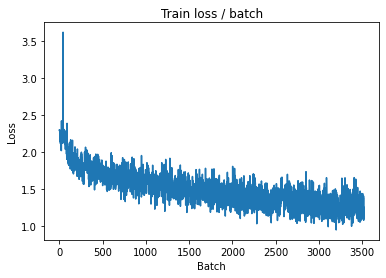

[TRAIN Batch 200/391]	Time 0.072s (0.057s)	Loss 1.1291 (1.2444)	Prec@1  63.3 ( 57.5)	Prec@5  93.0 ( 93.9)


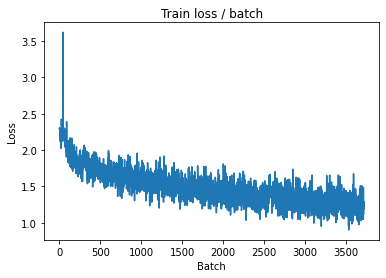


===============> Total time 22s	Avg loss 1.2444	Avg Prec@1 57.51 %	Avg Prec@5 93.88 %

[EVAL Batch 000/079]	Time 0.174s (0.174s)	Loss 1.2920 (1.2920)	Prec@1  60.9 ( 60.9)	Prec@5  93.8 ( 93.8)

===============> Total time 2s	Avg loss 1.1961	Avg Prec@1 60.80 %	Avg Prec@5 94.09 %



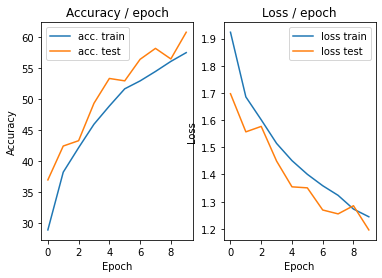

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.235s (0.235s)	Loss 1.2329 (1.2329)	Prec@1  58.6 ( 58.6)	Prec@5  94.5 ( 94.5)


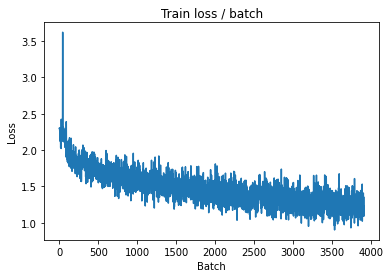

[TRAIN Batch 200/391]	Time 0.094s (0.057s)	Loss 1.3334 (1.2005)	Prec@1  57.0 ( 59.0)	Prec@5  93.8 ( 94.4)


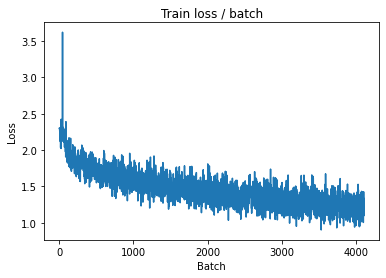


===============> Total time 22s	Avg loss 1.1976	Avg Prec@1 59.32 %	Avg Prec@5 94.28 %

[EVAL Batch 000/079]	Time 0.179s (0.179s)	Loss 1.1267 (1.1267)	Prec@1  62.5 ( 62.5)	Prec@5  94.5 ( 94.5)

===============> Total time 3s	Avg loss 1.2098	Avg Prec@1 60.23 %	Avg Prec@5 94.73 %



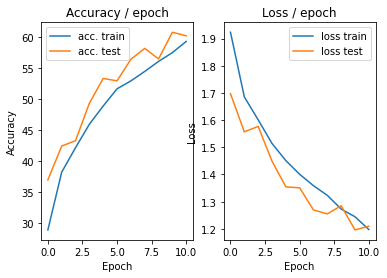

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.239s (0.239s)	Loss 1.0427 (1.0427)	Prec@1  68.0 ( 68.0)	Prec@5  96.9 ( 96.9)


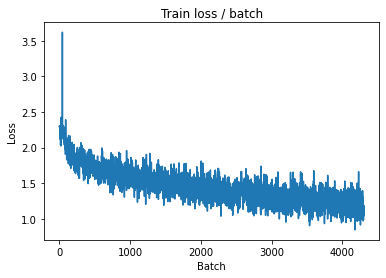

[TRAIN Batch 200/391]	Time 0.020s (0.057s)	Loss 1.2804 (1.1887)	Prec@1  54.7 ( 59.5)	Prec@5  90.6 ( 94.6)


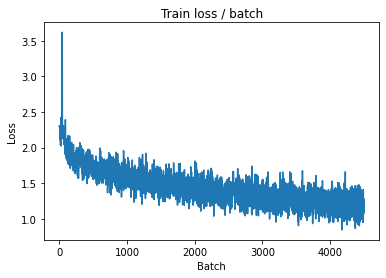


===============> Total time 22s	Avg loss 1.1730	Avg Prec@1 60.11 %	Avg Prec@5 94.77 %

[EVAL Batch 000/079]	Time 0.170s (0.170s)	Loss 1.2764 (1.2764)	Prec@1  61.7 ( 61.7)	Prec@5  95.3 ( 95.3)

===============> Total time 2s	Avg loss 1.1973	Avg Prec@1 58.95 %	Avg Prec@5 95.02 %



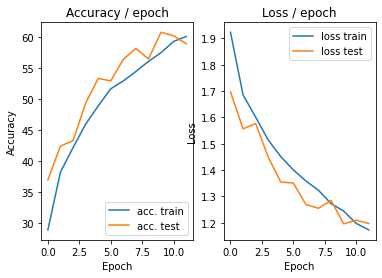

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.226s (0.226s)	Loss 1.1564 (1.1564)	Prec@1  56.2 ( 56.2)	Prec@5  96.1 ( 96.1)


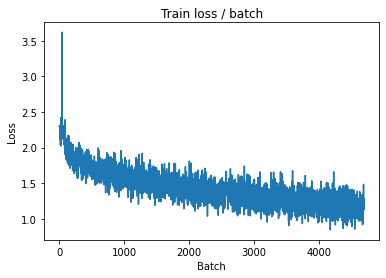

[TRAIN Batch 200/391]	Time 0.080s (0.056s)	Loss 1.1035 (1.1125)	Prec@1  60.9 ( 62.4)	Prec@5  95.3 ( 95.2)


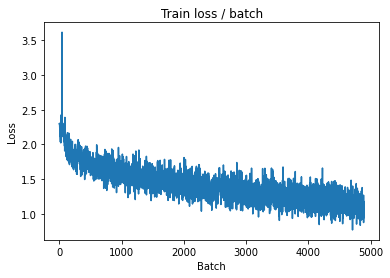


===============> Total time 21s	Avg loss 1.1133	Avg Prec@1 62.28 %	Avg Prec@5 95.20 %

[EVAL Batch 000/079]	Time 0.180s (0.180s)	Loss 1.0328 (1.0328)	Prec@1  64.1 ( 64.1)	Prec@5  95.3 ( 95.3)

===============> Total time 2s	Avg loss 1.1220	Avg Prec@1 62.05 %	Avg Prec@5 95.76 %



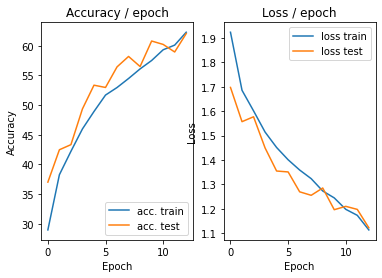

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.209s (0.209s)	Loss 1.2793 (1.2793)	Prec@1  59.4 ( 59.4)	Prec@5  94.5 ( 94.5)


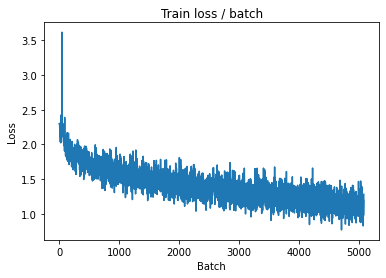

[TRAIN Batch 200/391]	Time 0.019s (0.057s)	Loss 0.9595 (1.0823)	Prec@1  66.4 ( 63.4)	Prec@5  96.1 ( 95.5)


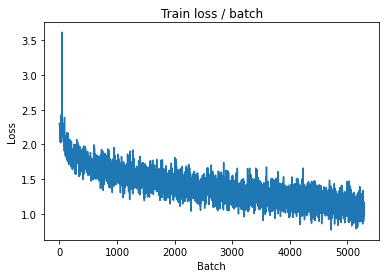


===============> Total time 22s	Avg loss 1.0849	Avg Prec@1 63.19 %	Avg Prec@5 95.39 %

[EVAL Batch 000/079]	Time 0.182s (0.182s)	Loss 1.0674 (1.0674)	Prec@1  69.5 ( 69.5)	Prec@5  96.1 ( 96.1)

===============> Total time 2s	Avg loss 1.0976	Avg Prec@1 63.24 %	Avg Prec@5 95.31 %



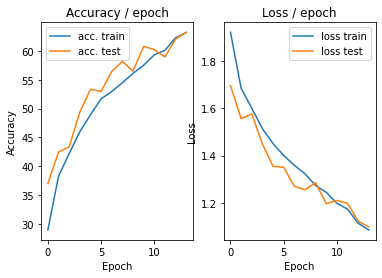

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.207s (0.207s)	Loss 1.0599 (1.0599)	Prec@1  65.6 ( 65.6)	Prec@5  96.1 ( 96.1)


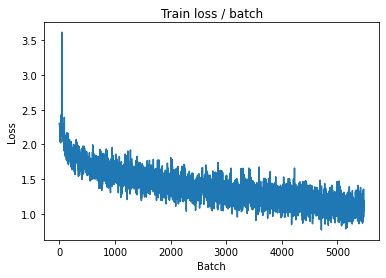

[TRAIN Batch 200/391]	Time 0.080s (0.057s)	Loss 0.9533 (1.0510)	Prec@1  67.2 ( 64.2)	Prec@5  96.1 ( 95.7)


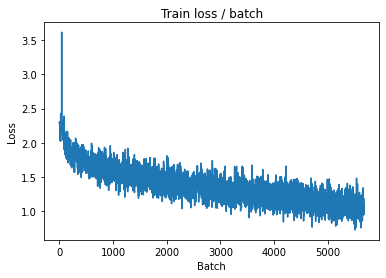


===============> Total time 21s	Avg loss 1.0457	Avg Prec@1 64.50 %	Avg Prec@5 95.77 %

[EVAL Batch 000/079]	Time 0.178s (0.178s)	Loss 1.0356 (1.0356)	Prec@1  65.6 ( 65.6)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.0709	Avg Prec@1 63.91 %	Avg Prec@5 95.84 %



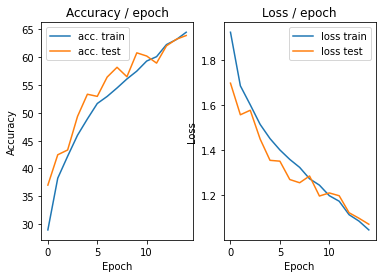

In [34]:
main6(128, 0.1, epochs=15 ,cuda=True)

### 3.4 Régularisation du réseau par dropout

In [36]:
class ConvNet7(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet7, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1000, 10),
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv

        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input

        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201]),
            transforms.RandomCrop(28),
            transforms.RandomHorizontalFlip(),
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201]),
            transforms.CenterCrop(28),
 
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss

def main7(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet7()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
    lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

        lr_sched.step()

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.456s (0.456s)	Loss 2.2993 (2.2993)	Prec@1  10.9 ( 10.9)	Prec@5  52.3 ( 52.3)


<Figure size 432x288 with 0 Axes>

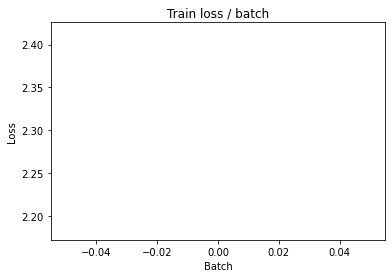

[TRAIN Batch 200/391]	Time 0.096s (0.059s)	Loss 2.3023 (2.2565)	Prec@1   8.6 ( 15.1)	Prec@5  50.8 ( 61.2)


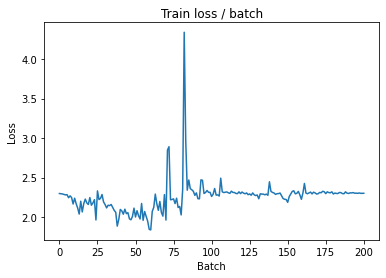


===============> Total time 22s	Avg loss 2.2799	Avg Prec@1 12.83 %	Avg Prec@5 55.76 %

[EVAL Batch 000/079]	Time 0.179s (0.179s)	Loss 2.3078 (2.3078)	Prec@1   7.8 (  7.8)	Prec@5  49.2 ( 49.2)

===============> Total time 2s	Avg loss 2.3056	Avg Prec@1  9.89 %	Avg Prec@5 49.65 %



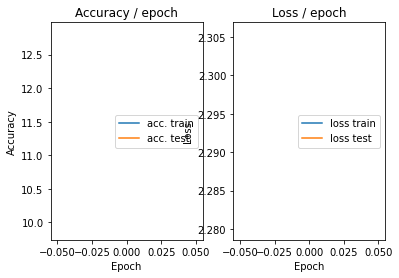

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.214s (0.214s)	Loss 2.3156 (2.3156)	Prec@1   7.8 (  7.8)	Prec@5  50.8 ( 50.8)


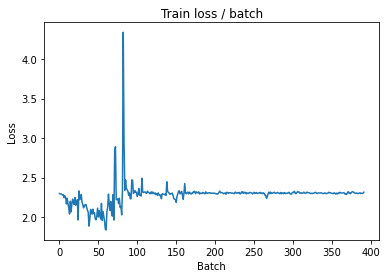

[TRAIN Batch 200/391]	Time 0.028s (0.057s)	Loss 2.3109 (2.3045)	Prec@1   5.5 (  9.9)	Prec@5  47.7 ( 50.0)


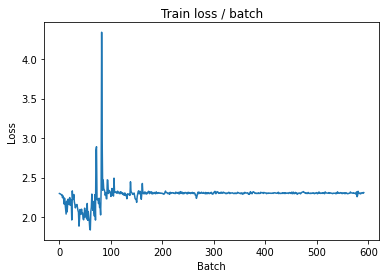


===============> Total time 22s	Avg loss 2.3043	Avg Prec@1 10.04 %	Avg Prec@5 50.16 %

[EVAL Batch 000/079]	Time 0.186s (0.186s)	Loss 2.3000 (2.3000)	Prec@1  10.2 ( 10.2)	Prec@5  54.7 ( 54.7)

===============> Total time 2s	Avg loss 2.3037	Avg Prec@1 10.03 %	Avg Prec@5 49.86 %



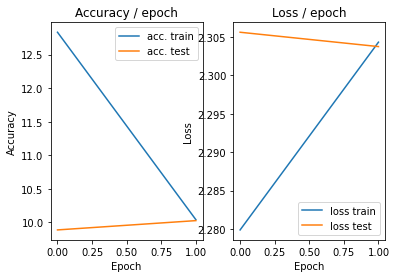

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.216s (0.216s)	Loss 2.3055 (2.3055)	Prec@1   9.4 (  9.4)	Prec@5  52.3 ( 52.3)


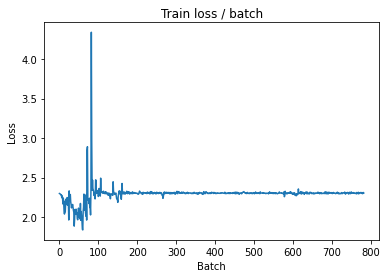

[TRAIN Batch 200/391]	Time 0.093s (0.057s)	Loss 2.2031 (2.2948)	Prec@1  21.9 ( 11.3)	Prec@5  69.5 ( 52.9)


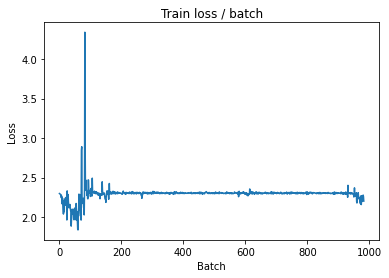


===============> Total time 22s	Avg loss 2.1697	Avg Prec@1 17.68 %	Avg Prec@5 64.65 %

[EVAL Batch 000/079]	Time 0.172s (0.172s)	Loss 1.9384 (1.9384)	Prec@1  36.7 ( 36.7)	Prec@5  82.0 ( 82.0)

===============> Total time 2s	Avg loss 1.9022	Avg Prec@1 30.26 %	Avg Prec@5 82.68 %



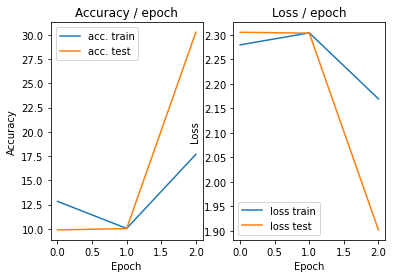

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.241s (0.241s)	Loss 1.8948 (1.8948)	Prec@1  35.2 ( 35.2)	Prec@5  84.4 ( 84.4)


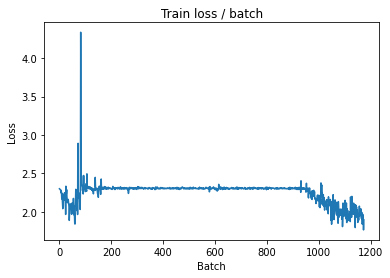

[TRAIN Batch 200/391]	Time 0.052s (0.058s)	Loss 1.9098 (1.8961)	Prec@1  30.5 ( 29.9)	Prec@5  83.6 ( 83.2)


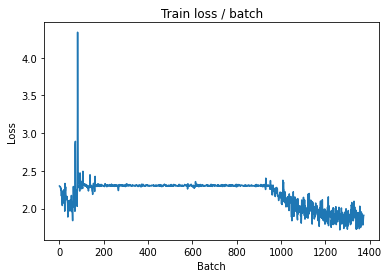


===============> Total time 22s	Avg loss 1.8831	Avg Prec@1 30.15 %	Avg Prec@5 83.64 %

[EVAL Batch 000/079]	Time 0.172s (0.172s)	Loss 1.8077 (1.8077)	Prec@1  36.7 ( 36.7)	Prec@5  85.2 ( 85.2)

===============> Total time 3s	Avg loss 1.7683	Avg Prec@1 34.74 %	Avg Prec@5 86.64 %



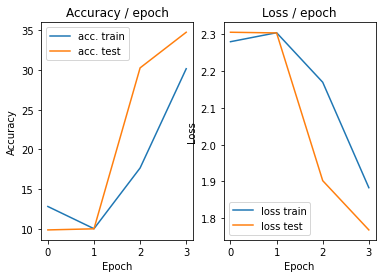

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.220s (0.220s)	Loss 1.9447 (1.9447)	Prec@1  25.0 ( 25.0)	Prec@5  80.5 ( 80.5)


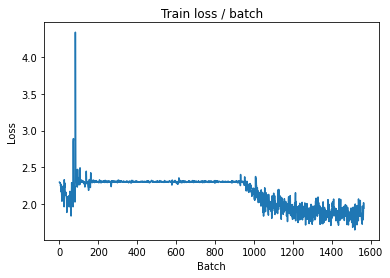

[TRAIN Batch 200/391]	Time 0.019s (0.058s)	Loss 1.8956 (1.8276)	Prec@1  28.9 ( 31.7)	Prec@5  84.4 ( 85.3)


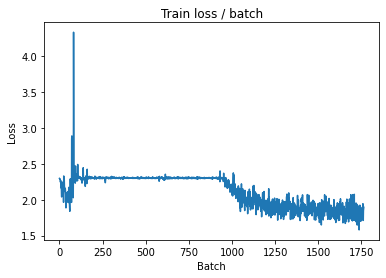


===============> Total time 22s	Avg loss 1.8051	Avg Prec@1 32.63 %	Avg Prec@5 85.93 %

[EVAL Batch 000/079]	Time 0.159s (0.159s)	Loss 1.7251 (1.7251)	Prec@1  41.4 ( 41.4)	Prec@5  87.5 ( 87.5)

===============> Total time 2s	Avg loss 1.7662	Avg Prec@1 36.23 %	Avg Prec@5 86.62 %



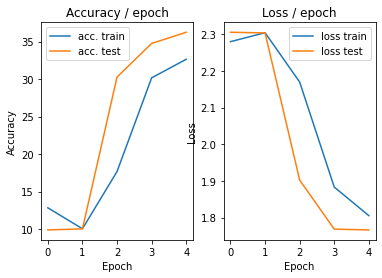

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.218s (0.218s)	Loss 1.9502 (1.9502)	Prec@1  35.9 ( 35.9)	Prec@5  82.8 ( 82.8)


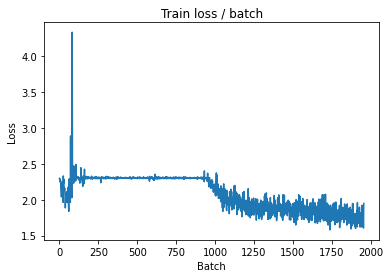

[TRAIN Batch 200/391]	Time 0.076s (0.058s)	Loss 1.5859 (1.7515)	Prec@1  40.6 ( 35.0)	Prec@5  88.3 ( 86.7)


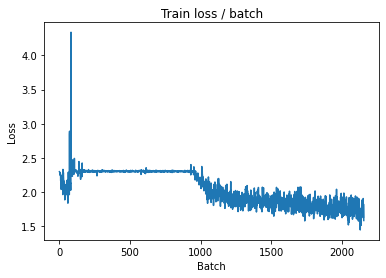


===============> Total time 22s	Avg loss 1.7460	Avg Prec@1 35.41 %	Avg Prec@5 86.83 %

[EVAL Batch 000/079]	Time 0.167s (0.167s)	Loss 1.6627 (1.6627)	Prec@1  37.5 ( 37.5)	Prec@5  85.9 ( 85.9)

===============> Total time 3s	Avg loss 1.6185	Avg Prec@1 40.43 %	Avg Prec@5 89.69 %



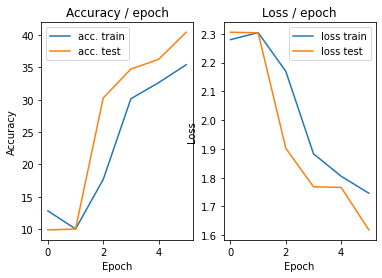

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.227s (0.227s)	Loss 1.7659 (1.7659)	Prec@1  34.4 ( 34.4)	Prec@5  85.9 ( 85.9)


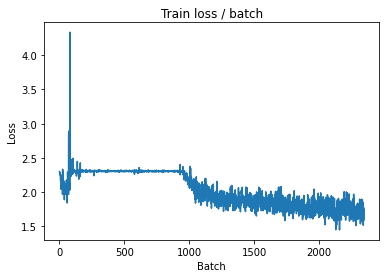

[TRAIN Batch 200/391]	Time 0.098s (0.058s)	Loss 1.7615 (1.6985)	Prec@1  39.8 ( 37.5)	Prec@5  85.9 ( 88.2)


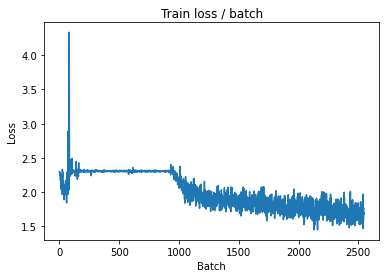


===============> Total time 22s	Avg loss 1.6872	Avg Prec@1 38.10 %	Avg Prec@5 88.32 %

[EVAL Batch 000/079]	Time 0.164s (0.164s)	Loss 1.7278 (1.7278)	Prec@1  33.6 ( 33.6)	Prec@5  86.7 ( 86.7)

===============> Total time 2s	Avg loss 1.6299	Avg Prec@1 39.73 %	Avg Prec@5 88.90 %



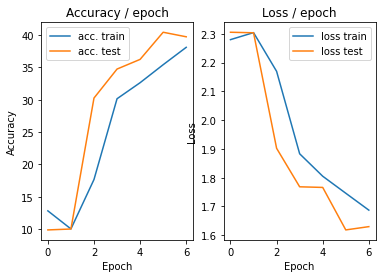

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.227s (0.227s)	Loss 1.6558 (1.6558)	Prec@1  39.8 ( 39.8)	Prec@5  89.1 ( 89.1)


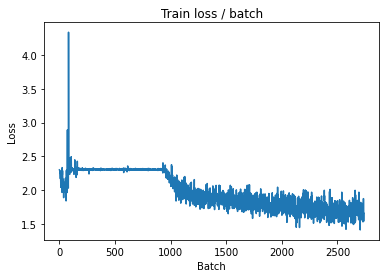

[TRAIN Batch 200/391]	Time 0.024s (0.057s)	Loss 1.6155 (1.6371)	Prec@1  40.6 ( 39.7)	Prec@5  85.2 ( 89.5)


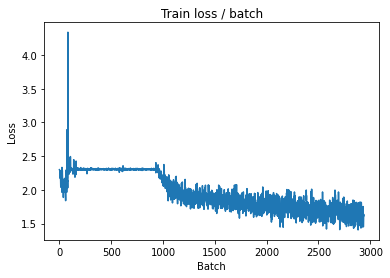


===============> Total time 22s	Avg loss 1.6257	Avg Prec@1 40.55 %	Avg Prec@5 89.60 %

[EVAL Batch 000/079]	Time 0.169s (0.169s)	Loss 1.5654 (1.5654)	Prec@1  46.1 ( 46.1)	Prec@5  86.7 ( 86.7)

===============> Total time 3s	Avg loss 1.4972	Avg Prec@1 46.08 %	Avg Prec@5 91.16 %



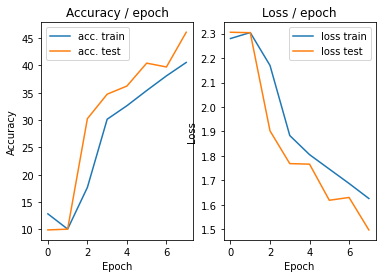

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.225s (0.225s)	Loss 1.5188 (1.5188)	Prec@1  43.8 ( 43.8)	Prec@5  90.6 ( 90.6)


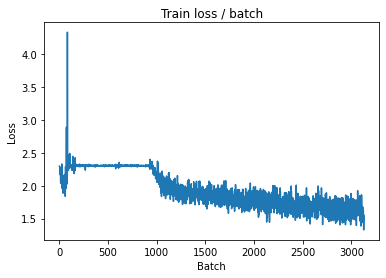

[TRAIN Batch 200/391]	Time 0.025s (0.057s)	Loss 1.7700 (1.5678)	Prec@1  32.8 ( 42.7)	Prec@5  89.1 ( 90.5)


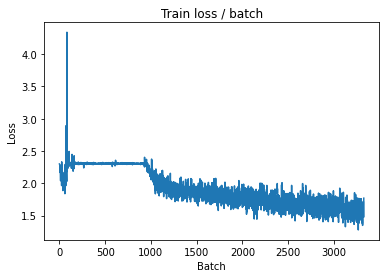


===============> Total time 21s	Avg loss 1.5558	Avg Prec@1 43.35 %	Avg Prec@5 90.58 %

[EVAL Batch 000/079]	Time 0.179s (0.179s)	Loss 1.3428 (1.3428)	Prec@1  52.3 ( 52.3)	Prec@5  90.6 ( 90.6)

===============> Total time 2s	Avg loss 1.4329	Avg Prec@1 48.45 %	Avg Prec@5 92.49 %



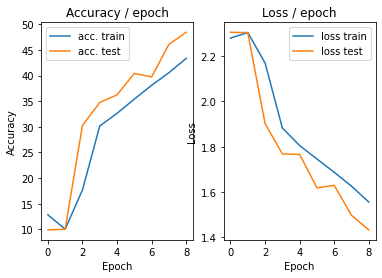

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.223s (0.223s)	Loss 1.6663 (1.6663)	Prec@1  44.5 ( 44.5)	Prec@5  90.6 ( 90.6)


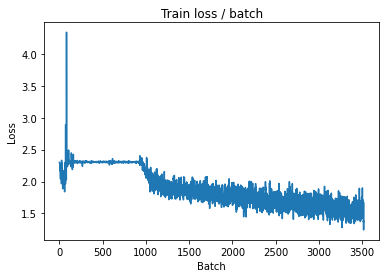

[TRAIN Batch 200/391]	Time 0.024s (0.057s)	Loss 1.5532 (1.5456)	Prec@1  42.2 ( 44.2)	Prec@5  89.1 ( 90.6)


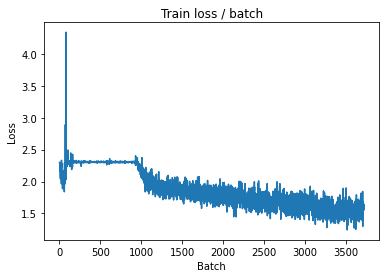


===============> Total time 22s	Avg loss 1.5288	Avg Prec@1 44.80 %	Avg Prec@5 90.84 %

[EVAL Batch 000/079]	Time 0.166s (0.166s)	Loss 1.4512 (1.4512)	Prec@1  43.8 ( 43.8)	Prec@5  90.6 ( 90.6)

===============> Total time 2s	Avg loss 1.4326	Avg Prec@1 48.36 %	Avg Prec@5 91.93 %



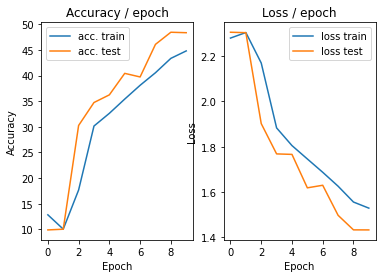

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.243s (0.243s)	Loss 1.3947 (1.3947)	Prec@1  50.0 ( 50.0)	Prec@5  93.0 ( 93.0)


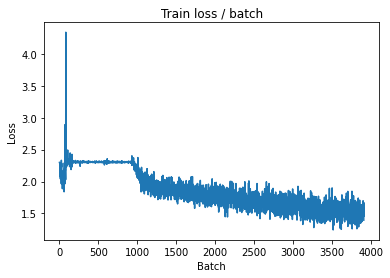

[TRAIN Batch 200/391]	Time 0.095s (0.057s)	Loss 1.3225 (1.5035)	Prec@1  52.3 ( 46.1)	Prec@5  94.5 ( 91.3)


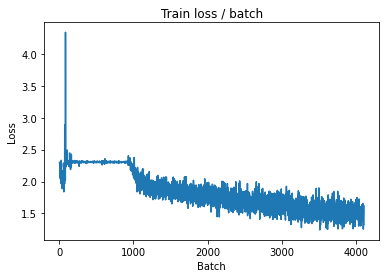


===============> Total time 22s	Avg loss 1.4995	Avg Prec@1 46.19 %	Avg Prec@5 91.49 %

[EVAL Batch 000/079]	Time 0.174s (0.174s)	Loss 1.3880 (1.3880)	Prec@1  51.6 ( 51.6)	Prec@5  93.0 ( 93.0)

===============> Total time 2s	Avg loss 1.3886	Avg Prec@1 51.13 %	Avg Prec@5 92.74 %



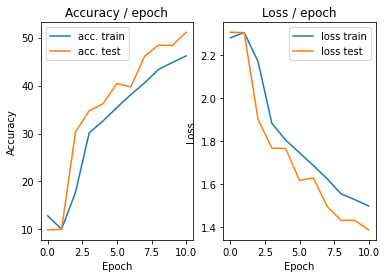

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.216s (0.216s)	Loss 1.3451 (1.3451)	Prec@1  45.3 ( 45.3)	Prec@5  94.5 ( 94.5)


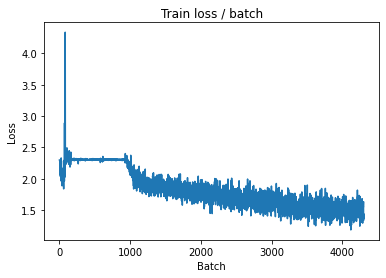

[TRAIN Batch 200/391]	Time 0.025s (0.056s)	Loss 1.4139 (1.4831)	Prec@1  47.7 ( 47.0)	Prec@5  89.8 ( 91.4)


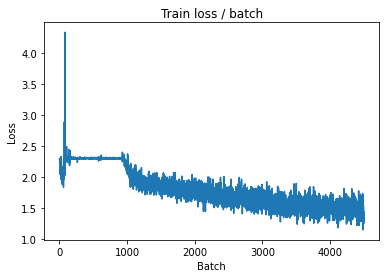


===============> Total time 21s	Avg loss 1.4675	Avg Prec@1 47.54 %	Avg Prec@5 91.68 %

[EVAL Batch 000/079]	Time 0.168s (0.168s)	Loss 1.3302 (1.3302)	Prec@1  50.0 ( 50.0)	Prec@5  93.8 ( 93.8)

===============> Total time 2s	Avg loss 1.3433	Avg Prec@1 51.33 %	Avg Prec@5 93.26 %



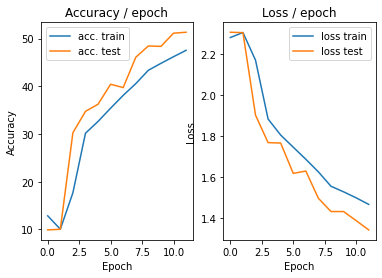

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.221s (0.221s)	Loss 1.4922 (1.4922)	Prec@1  43.0 ( 43.0)	Prec@5  94.5 ( 94.5)


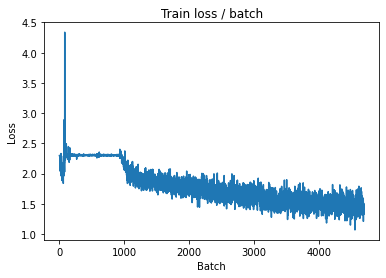

[TRAIN Batch 200/391]	Time 0.024s (0.056s)	Loss 1.3331 (1.3892)	Prec@1  53.9 ( 50.8)	Prec@5  92.2 ( 92.7)


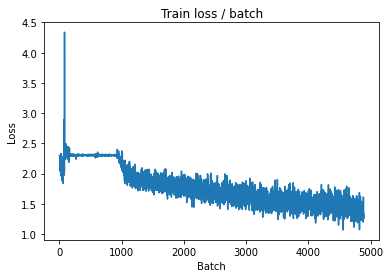


===============> Total time 21s	Avg loss 1.3940	Avg Prec@1 50.92 %	Avg Prec@5 92.52 %

[EVAL Batch 000/079]	Time 0.178s (0.178s)	Loss 1.4056 (1.4056)	Prec@1  50.8 ( 50.8)	Prec@5  87.5 ( 87.5)

===============> Total time 2s	Avg loss 1.3138	Avg Prec@1 53.50 %	Avg Prec@5 94.00 %



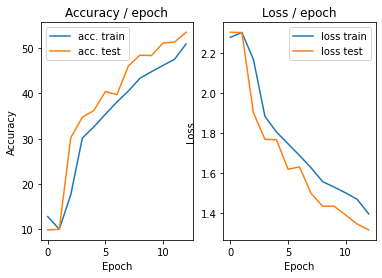

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.218s (0.218s)	Loss 1.4413 (1.4413)	Prec@1  50.8 ( 50.8)	Prec@5  93.0 ( 93.0)


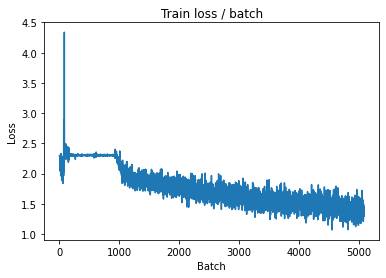

[TRAIN Batch 200/391]	Time 0.020s (0.057s)	Loss 1.3750 (1.3713)	Prec@1  50.8 ( 51.6)	Prec@5  89.1 ( 93.0)


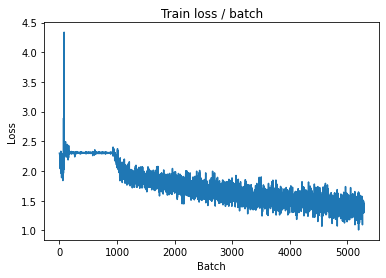


===============> Total time 22s	Avg loss 1.3657	Avg Prec@1 52.07 %	Avg Prec@5 92.94 %

[EVAL Batch 000/079]	Time 0.177s (0.177s)	Loss 1.1961 (1.1961)	Prec@1  58.6 ( 58.6)	Prec@5  95.3 ( 95.3)

===============> Total time 2s	Avg loss 1.2385	Avg Prec@1 56.76 %	Avg Prec@5 94.29 %



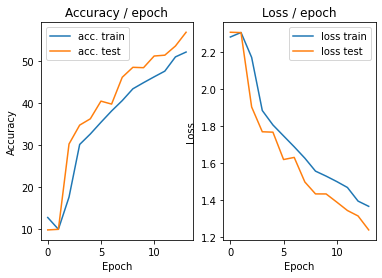

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.218s (0.218s)	Loss 1.2875 (1.2875)	Prec@1  60.2 ( 60.2)	Prec@5  94.5 ( 94.5)


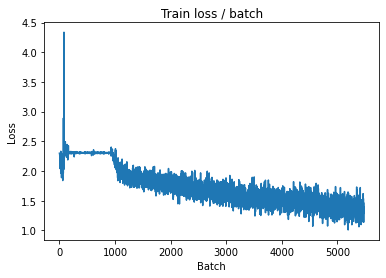

[TRAIN Batch 200/391]	Time 0.027s (0.057s)	Loss 1.0397 (1.3276)	Prec@1  62.5 ( 53.6)	Prec@5  95.3 ( 93.3)


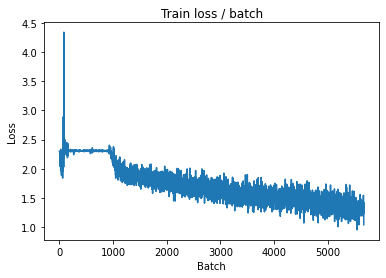


===============> Total time 22s	Avg loss 1.3206	Avg Prec@1 53.63 %	Avg Prec@5 93.38 %

[EVAL Batch 000/079]	Time 0.179s (0.179s)	Loss 1.1910 (1.1910)	Prec@1  57.0 ( 57.0)	Prec@5  93.0 ( 93.0)

===============> Total time 3s	Avg loss 1.2284	Avg Prec@1 57.27 %	Avg Prec@5 94.69 %



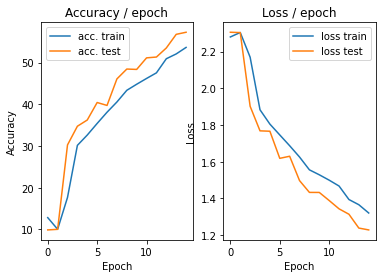

In [40]:
main7(128, 0.1, epochs=15 ,cuda=True)

### 3.5 Utilisation de batch normalization